In [1]:
import numpy as np
import torch
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
num_time_steps = 500
x = np.linspace(0.0,1.0,num=128)
dx = 1.0/np.shape(x)[0]
tsteps = np.linspace(0.0,2.0,num=num_time_steps)
dt = 2.0/np.shape(tsteps)[0]
time_window = 40 # The window size of the LSTM

In [3]:
def exact_solution(Rnum,t):
    t0 = np.exp(Rnum/8.0)
    return (x/(t+1))/(1.0+np.sqrt((t+1)/t0)*np.exp(Rnum*(x*x)/(4.0*t+4)))

def collect_snapshots(Rnum):
    snapshot_matrix = np.zeros(shape=(np.shape(x)[0],np.shape(tsteps)[0]))

    trange = np.arange(np.shape(tsteps)[0])
    for t in trange:
        snapshot_matrix[:,t] = exact_solution(Rnum,tsteps[t])[:]

    return snapshot_matrix

def collect_multiparam_snapshots_train():
    rnum_vals_1 = np.arange(600,850,25)[:, None]
    rnum_vals_2 = np.arange(1100,2250,25)[:, None]
    rnum_vals = np.concatenate((rnum_vals_1, rnum_vals_2), axis = 0).squeeze()
    
    rsnap = 0
    for rnum_val in rnum_vals:
        snapshots_temp = np.transpose(collect_snapshots(rnum_val))
        
        if rsnap == 0:
            all_snapshots = snapshots_temp
        else:
            
            all_snapshots = np.concatenate((all_snapshots,snapshots_temp),axis=0)
            
        rsnap = rsnap + 1    
    return all_snapshots, rnum_vals/1000

def collect_multiparam_snapshots_test():
    rnum_vals = np.arange(550,2755,475)
    
    rsnap = 0
    for rnum_val in rnum_vals:
        snapshots_temp = np.transpose(collect_snapshots(rnum_val))
        
        if rsnap == 0:
            all_snapshots = snapshots_temp
        else:
            
            all_snapshots = np.concatenate((all_snapshots,snapshots_temp),axis=0)
            
        rsnap = rsnap + 1    
    return all_snapshots, rnum_vals/1000

In [4]:
snapshots_train, rnum_vals_train = collect_multiparam_snapshots_train() # So that dim=0 corresponds to number of snapshots
snapshots_test, rnum_vals_test = collect_multiparam_snapshots_test() # So that dim=0 corresponds to number of snapshots

In [5]:
print("Train vals: ", rnum_vals_train)
print()
print("Val vals: ", rnum_vals_test)

Train vals:  [0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 1.1   1.125
 1.15  1.175 1.2   1.225 1.25  1.275 1.3   1.325 1.35  1.375 1.4   1.425
 1.45  1.475 1.5   1.525 1.55  1.575 1.6   1.625 1.65  1.675 1.7   1.725
 1.75  1.775 1.8   1.825 1.85  1.875 1.9   1.925 1.95  1.975 2.    2.025
 2.05  2.075 2.1   2.125 2.15  2.175 2.2   2.225]

Val vals:  [0.55  1.025 1.5   1.975 2.45 ]


In [6]:
print(snapshots_train.shape)
print(snapshots_test.shape)
print(len(rnum_vals_train))

(28000, 128)
(2500, 128)
56


# Define the AE rchitecture

In [7]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim=2, feats=[512, 256, 128, 64, 32]):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self._net = nn.Sequential(
            nn.Linear(input_dim, feats[0]),
            nn.GELU(),
            nn.Linear(feats[0], feats[1]),
            nn.GELU(),
            nn.Linear(feats[1], feats[2]),
            nn.GELU(),
            nn.Linear(feats[2], feats[3]),
            nn.GELU(),
            nn.Linear(feats[3], feats[4]),
            nn.GELU(),
            nn.Linear(feats[4], latent_dim)
        )

    def forward(self, x):
      Z = self._net(x)
      return Z


class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, feats=[32, 64, 128, 256, 512]):
        super(Decoder, self).__init__()
        self.output_dim = output_dim
        self._net = nn.Sequential(
            nn.Linear(latent_dim, feats[0]),
            nn.GELU(),
            nn.Linear(feats[0], feats[1]),
            nn.GELU(),
            nn.Linear(feats[1], feats[2]),
            nn.GELU(),
            nn.Linear(feats[2], feats[3]),
            nn.GELU(),
            nn.Linear(feats[3], feats[4]),
            nn.GELU(),
            nn.Linear(feats[4], output_dim),
        )

    def forward(self, x):
      y = self._net(x)
      return y


class Model(nn.Module):
    def __init__(self, encoder, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.decoder = decoder # decoder for x(t)

    def forward(self, x):
        z = self.encoder(x)
        # Reconstruction
        x_hat = self.decoder(z)  # Reconstruction of x(t)

        return x_hat

In [8]:
# Creating the data loaders
train_loader = DataLoader(snapshots_train, batch_size=32, shuffle=True)
test_loader = DataLoader(snapshots_test, batch_size=32, shuffle=False)

# Defining the loss function
def mse_loss(x, x_hat):
    return torch.mean((x - x_hat)**2)

# Instantiating the model:
encoder = Encoder(input_dim = 128)
decoder = Decoder(latent_dim = 2, output_dim=128)
model = Model(encoder, decoder)

# Instantiating the optimizer:
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [9]:
num_epochs = 500
model.train()  # Set the model to training mode
model = model.cuda()  # Move the model to GPU

for epoch in range(num_epochs):  # Correct loop for epochs
    epoch_loss = 0.0  # Track loss for the epoch
    
    # Training Loop
    model.train()
    for data in train_loader:  # Loop over batches from DataLoader
        data = data.float().cuda()  # Move data to GPU
        
        # Forward pass
        data_hat = model(data)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Compute loss
        loss = mse_loss(data, data_hat)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Accumulate loss
        epoch_loss += loss.item()
    
    # Validation Loop
    validation_loss = 0.0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation for validation
        for data in test_loader:
            data = data.float().cuda()  # Move data to GPU        
            # Forward pass
            data_hat = model(data)
            # Compute loss
            loss = mse_loss(data, data_hat)
            validation_loss += loss.item()  # Accumulate validation loss
    
    #print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f} --- Validation Loss: {validation_loss:.4f}")


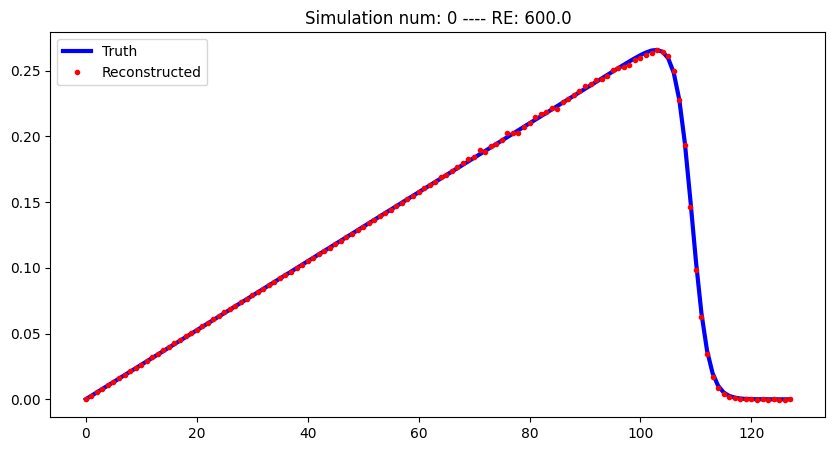

In [10]:
model = model.cpu()

sim_num = np.random.randint(0, len(rnum_vals_train))
input_1 = torch.tensor(snapshots_train[(sim_num+1)*(num_time_steps-1):(sim_num+1)*(num_time_steps-1)+1,:], dtype = torch.float32)
recoded_1 = model(input_1).cpu().detach().numpy()

plt.figure(figsize=(10,5))
plt.plot(snapshots_train[(sim_num+1)*(num_time_steps-1),:],'b',label='Truth',linewidth=3)
plt.plot(recoded_1.squeeze(),'ro',label='Reconstructed',markersize=3)
plt.legend()
plt.title(f"Simulation num: {sim_num} ---- RE: {rnum_vals_train[sim_num]*1000}")
plt.show()

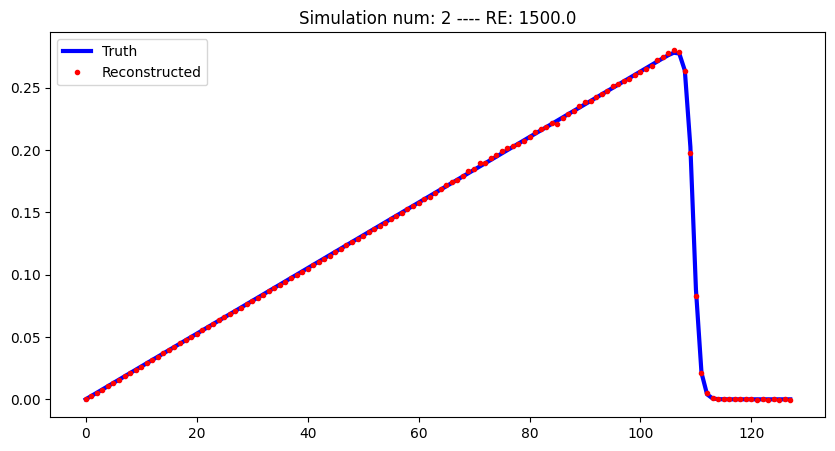

In [11]:
sim_num = np.random.randint(0, len(rnum_vals_test))
input_1 = torch.tensor(snapshots_test[(sim_num+1)*(num_time_steps-1):(sim_num+1)*(num_time_steps-1)+1,:], dtype = torch.float32)
recoded_1 = model(input_1).cpu().detach().numpy()

plt.figure(figsize=(10,5))
plt.plot(snapshots_test[(sim_num+1)*(num_time_steps-1),:],'b',label='Truth',linewidth=3)
plt.plot(recoded_1.squeeze(),'ro',label='Reconstructed',markersize=3)
plt.legend()
plt.title(f"Simulation num: {sim_num} ---- RE: {rnum_vals_test[sim_num]*1000}")
plt.show()

In [12]:
print("Train Rnum:\n ",rnum_vals_train*1000)
print("Test Rnum:\n ",rnum_vals_test*1000)

Train Rnum:
  [ 600.  625.  650.  675.  700.  725.  750.  775.  800.  825. 1100. 1125.
 1150. 1175. 1200. 1225. 1250. 1275. 1300. 1325. 1350. 1375. 1400. 1425.
 1450. 1475. 1500. 1525. 1550. 1575. 1600. 1625. 1650. 1675. 1700. 1725.
 1750. 1775. 1800. 1825. 1850. 1875. 1900. 1925. 1950. 1975. 2000. 2025.
 2050. 2075. 2100. 2125. 2150. 2175. 2200. 2225.]
Test Rnum:
  [ 550. 1025. 1500. 1975. 2450.]


In [13]:
encoded = encoder(torch.tensor(snapshots_train[:,:], dtype = torch.float32)).cpu().detach().numpy()
# Reshape
encoded = encoded.reshape(len(rnum_vals_train),num_time_steps,2)
print("Training data encoded: ", encoded.shape)

encoded_test = encoder(torch.tensor(snapshots_test[:,:], dtype = torch.float32)).cpu().detach().numpy()
# Reshape
encoded_test = encoded_test.reshape(len(rnum_vals_test),num_time_steps,2)
print("Testing data encoded: ", encoded_test.shape)


# smoothing the latents:
from scipy.ndimage.filters import gaussian_filter1d
encoded_f = np.copy(encoded)
encoded_test_f = np.copy(encoded_test)

for rnum in range(len(rnum_vals_train)):
    encoded_f[rnum,:,0] = gaussian_filter1d(encoded[rnum,:,0],sigma=3)
    encoded_f[rnum,:,1] = gaussian_filter1d(encoded[rnum,:,1],sigma=3)

for rnum in range(len(rnum_vals_test)):
    encoded_test_f[rnum,:,0] = gaussian_filter1d(encoded_test[rnum,:,0],sigma=3)
    encoded_test_f[rnum,:,1] = gaussian_filter1d(encoded_test[rnum,:,1],sigma=3)

print("Training data encoded: ", encoded_f.shape)
print("Testing data encoded: ", encoded_test_f.shape)

Training data encoded:  (56, 500, 2)
Testing data encoded:  (5, 500, 2)
Training data encoded:  (56, 500, 2)
Testing data encoded:  (5, 500, 2)


/tmp/ipykernel_2217846/189125315.py:13: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


In [14]:
# for i in range(len(rnum_vals_train)):
#     plt.figure(figsize=(7,6))
#     plt.plot(encoded_f[i,:,0],label='Latent dimension 1')
#     plt.plot(encoded_f[i,:,1],label='Latent dimension 2')
#     plt.legend()
#     plt.xlabel('Temporal snapshot')
#     plt.ylabel('Magnitude')
#     plt.show()

In [15]:
# for i in range(len(rnum_vals_test)):
#     plt.figure(figsize=(7,6))
#     plt.plot(encoded_test_f[i,:,0],label='Latent dimension 1')
#     plt.plot(encoded_test_f[i,:,1],label='Latent dimension 2')
#     plt.legend()
#     plt.xlabel('Temporal snapshot')
#     plt.ylabel('Magnitude')
#     plt.show()

In [16]:
time_window = 40

In [17]:
num_train_snapshots = np.shape(rnum_vals_train)[0]

rnum_tracker = np.zeros(shape=(num_train_snapshots,num_time_steps,1))
for i in range(np.shape(rnum_vals_train)[0]):
    rnum_tracker[i,:,0] = rnum_vals_train[i]
    
lstm_training_data = np.concatenate((encoded,rnum_tracker),axis=-1)

total_size = np.shape(lstm_training_data)[0]*np.shape(lstm_training_data)[1]
total_size_sim = np.shape(lstm_training_data)[1]

# Shape the inputs and outputs
input_seq = np.zeros(shape=(total_size-num_train_snapshots*time_window,time_window,3))
output_seq = np.zeros(shape=(total_size-num_train_snapshots*time_window,2))

# Setting up inputs
sample = 0
for snum in range(num_train_snapshots):
    for t in range(time_window,total_size_sim):
        input_seq[sample,:,:] = lstm_training_data[snum,t-time_window:t,:]
        output_seq[sample,:] = lstm_training_data[snum,t,0:2]
        sample = sample + 1

In [18]:
print("Input sequence shape:", input_seq.shape)
print("Output sequence shape:", output_seq.shape)
print("Input sequence sample:\n", input_seq[:1])  # Print the first sample
print("Output sequence sample:\n", output_seq[:1])  # Print the first sample


print("Input sequence type:", type(input_seq))
print("Output sequence type:", type(output_seq))
print("Input sequence dtype:", input_seq.dtype)
print("Output sequence dtype:", output_seq.dtype)

input_seq = input_seq.astype('float32')
output_seq = output_seq.astype('float32')

print("NaNs in input_seq:", np.isnan(input_seq).any())
print("NaNs in output_seq:", np.isnan(output_seq).any())

Input sequence shape: (25760, 40, 3)
Output sequence shape: (25760, 2)
Input sequence sample:
 [[[ 3.15159798e+01  9.18816757e+01  6.00000000e-01]
  [ 2.98774662e+01  8.88551407e+01  6.00000000e-01]
  [ 2.77324734e+01  8.56241455e+01  6.00000000e-01]
  [ 2.53398895e+01  8.22144089e+01  6.00000000e-01]
  [ 2.33354530e+01  7.87919846e+01  6.00000000e-01]
  [ 2.17073841e+01  7.53962860e+01  6.00000000e-01]
  [ 2.03730488e+01  7.20676727e+01  6.00000000e-01]
  [ 1.88005524e+01  6.92405090e+01  6.00000000e-01]
  [ 1.74502888e+01  6.64848480e+01  6.00000000e-01]
  [ 1.65376492e+01  6.37185020e+01  6.00000000e-01]
  [ 1.59639263e+01  6.09949913e+01  6.00000000e-01]
  [ 1.55940342e+01  5.83451881e+01  6.00000000e-01]
  [ 1.53809357e+01  5.57631569e+01  6.00000000e-01]
  [ 1.52175493e+01  5.32716713e+01  6.00000000e-01]
  [ 1.48169403e+01  5.09517250e+01  6.00000000e-01]
  [ 1.41938686e+01  4.87838707e+01  6.00000000e-01]
  [ 1.33886442e+01  4.66993752e+01  6.00000000e-01]
  [ 1.23653822e+01  4

In [19]:
# Convert to PyTorch tensors
X_tensor = torch.from_numpy(input_seq).float()  # [N, time_window, 3]
y_tensor = torch.from_numpy(output_seq).float() # [N, 2]

print(X_tensor.shape, y_tensor.shape)

torch.Size([25760, 40, 3]) torch.Size([25760, 2])


In [20]:
# print("First Input Seq\n", X_tensor[0, :, :])
# print("First Target\n",y_tensor[0, :])

In [21]:
# print("Second Input Seq\n", X_tensor[1, :, :])
# print("Second Target\n",y_tensor[1, :])

In [22]:
# print("Third Input Seq\n", X_tensor[2, :, :])
# print("Third Target\n",y_tensor[2, :])

In [23]:
class PytorchLSTM(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=80, output_dim=2):
        super().__init__()
        # First LSTM: simulates return_sequences=True
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        # Second LSTM: simulates return_sequences=False
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """
        x shape: [batch_size, time_window, input_dim]
        """
        # LSTM1 (return_sequences=True)
        out1, (h1, c1) = self.lstm1(x)
        # out1 shape: [batch_size, time_window, hidden_dim]

        # LSTM2 (return_sequences=False -> we only use the last time step)
        out2, (h2, c2) = self.lstm2(out1)
        # out2 shape: [batch_size, time_window, hidden_dim]
        # Last timestep (since we didn't set return_sequences=True)
        # is effectively out2[:, -1, :], but PyTorch LSTM always returns full seq unless you slice.

        last_timestep = out2[:, -1, :]  # shape: [batch_size, hidden_dim]

        # Dense -> 2 outputs
        output = self.fc(last_timestep)  # shape: [batch_size, 2]
        return output

In [24]:
# Wrap in a Dataset & DataLoader for batching
dataset = TensorDataset(X_tensor, y_tensor)
batch_size = 32
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# --------------- MODEL ---------------
lstm_model = PytorchLSTM(input_dim=3, hidden_dim=40, output_dim=2)
print(lstm_model)

# --------------- OPTIMIZER ---------------
optimizer = optim.Adam(
    lstm_model.parameters(), 
    lr=0.00005, # try but increase epochs to 2500 
    betas=(0.9, 0.999), 
    amsgrad=False
)

# --------------- LOSS FUNCTION ---------------
criterion = nn.MSELoss()

# --------------- TRAINING LOOP ---------------
num_epochs = 2000 
patience = 20       # early stopping patience
best_loss = float('inf')
epochs_no_improve = 0

lstm_filepath = "lstm_weights_best_new.pth"  # your checkpoint path

for epoch in range(num_epochs):
    lstm_model.train()
    running_loss = 0.0
    
    for batch_X, batch_y in loader:
        optimizer.zero_grad()
        # Forward pass
        pred = lstm_model(batch_X)      # shape [batch_size, 2]
        loss = criterion(pred, batch_y)
        # Backward pass
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_X.size(0)
    
    epoch_loss = running_loss / len(dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}")

PytorchLSTM(
  (lstm1): LSTM(3, 40, batch_first=True)
  (lstm2): LSTM(40, 40, batch_first=True)
  (fc): Linear(in_features=40, out_features=2, bias=True)
)
Epoch [1/2000], Loss: 158.667404
Epoch [2/2000], Loss: 130.167411
Epoch [3/2000], Loss: 115.640621
Epoch [4/2000], Loss: 103.638471
Epoch [5/2000], Loss: 93.108565
Epoch [6/2000], Loss: 84.438670
Epoch [7/2000], Loss: 76.971022
Epoch [8/2000], Loss: 70.282539
Epoch [9/2000], Loss: 64.183337
Epoch [10/2000], Loss: 58.594611
Epoch [11/2000], Loss: 53.478110
Epoch [12/2000], Loss: 48.783327
Epoch [13/2000], Loss: 44.457683
Epoch [14/2000], Loss: 40.468955
Epoch [15/2000], Loss: 36.798100
Epoch [16/2000], Loss: 33.422517
Epoch [17/2000], Loss: 30.293134
Epoch [18/2000], Loss: 27.424617
Epoch [19/2000], Loss: 24.801644
Epoch [20/2000], Loss: 22.372195
Epoch [21/2000], Loss: 20.160152
Epoch [22/2000], Loss: 18.134022
Epoch [23/2000], Loss: 16.303693
Epoch [24/2000], Loss: 14.622553
Epoch [25/2000], Loss: 13.078823
Epoch [26/2000], Loss: 1

In [25]:
print(X_tensor.shape)
print(batch_X.shape)
print(batch_y.shape)

torch.Size([25760, 40, 3])
torch.Size([32, 40, 3])
torch.Size([32, 2])


In [26]:
pred = lstm_model(X_tensor)
print(pred.shape)

torch.Size([25760, 2])


In [27]:
num_train_snapshots = np.shape(rnum_vals_train)[0]
rnum_tracker = np.zeros(shape=(num_train_snapshots,num_time_steps,1))
for i in range(np.shape(rnum_vals_train)[0]):
    rnum_tracker[i,:,0] = rnum_vals_train[i]   
lstm_training_data = np.concatenate((encoded,rnum_tracker),axis=-1)



num_test_snapshots = np.shape(rnum_vals_test)[0]
rnum_tracker = np.zeros(shape=(num_test_snapshots,num_time_steps,1))

for i in range(np.shape(rnum_vals_test)[0]):
    rnum_tracker[i,:,0] = rnum_vals_test[i]  
lstm_testing_data = np.concatenate((encoded_test,rnum_tracker),axis=-1)


total_size = np.shape(lstm_testing_data)[0]*np.shape(lstm_testing_data)[1]
total_size_sim = np.shape(lstm_testing_data)[1]

# Shape the inputs and outputs
input_seq = np.zeros(shape=(1,time_window,3))
output_seq = np.zeros(shape=(total_size-num_test_snapshots*time_window,2))
output_seq_pred = np.zeros(shape=(total_size-num_test_snapshots*time_window,2))

print(lstm_training_data.shape)
print(lstm_testing_data.shape)

(56, 500, 3)
(5, 500, 3)


In [28]:
# Saving the lstm_testing_data:
np.save('lstm_testing_data.npy',lstm_testing_data)

In [29]:
print(lstm_training_data[0, 0, 2]*1000)
print(lstm_testing_data[0, 0, 2]*1000)

600.0
550.0


In [30]:
total_size_sim

500

In [31]:
lstm_model.eval()

PytorchLSTM(
  (lstm1): LSTM(3, 40, batch_first=True)
  (lstm2): LSTM(40, 40, batch_first=True)
  (fc): Linear(in_features=40, out_features=2, bias=True)
)

In [32]:
time_window = 40
num_train_snapshots, num_time_steps, _ = lstm_training_data.shape
total_size_sim = num_time_steps  # e.g. 500
num_predictions_per_snapshot = total_size_sim - time_window

# We'll store predictions and "ground truth" in arrays
output_seq_pred_train = np.zeros((num_train_snapshots * num_predictions_per_snapshot, 2), dtype=np.float32)
output_seq_train      = np.zeros((num_train_snapshots * num_predictions_per_snapshot, 2), dtype=np.float32)

input_seq_buff = np.zeros((1, time_window, 3), dtype=np.float32)

print(num_train_snapshots, num_time_steps, num_predictions_per_snapshot, output_seq_pred_train.shape, input_seq_buff.shape)

56 500 460 (25760, 2) (1, 40, 3)


In [33]:
sample = 0
with torch.no_grad():
    for snum in range(num_train_snapshots):
        # Initialize the first window
        input_seq_buff[0, :, :] = lstm_training_data[snum, 0:time_window, :]

        for t in range(time_window, total_size_sim):
            inp_tensor = torch.from_numpy(input_seq_buff).float()
            pred = lstm_model(inp_tensor)   # shape [1, 2]
            pred_np = pred.numpy()[0, :]

            # store predicted
            output_seq_pred_train[sample, :] = pred_np
            # store ground truth
            output_seq_train[sample, :] = lstm_training_data[snum, t, 0:2]

            # shift
            temp = input_seq_buff[0, 1:time_window, :].copy()
            input_seq_buff[0, 0:time_window-1, :] = temp
            input_seq_buff[0, time_window-1, 0:2] = pred_np
            # keep input_seq_buff[0, time_window-1, 2] the same if it’s a param

            sample += 1


In [34]:
print(output_seq_pred_train.shape)
print(output_seq_train.shape)

(25760, 2)
(25760, 2)


In [35]:
# Saving the Output prediction on train data and actual training sequence:

np.save('output_seq_train.npy',output_seq_train)
np.save('output_seq_pred_train.npy',output_seq_pred_train)

In [36]:
print("Training Sequence Predicted:/n: ", output_seq_pred_train[0:10, :])
print("Training Sequence Original:/n: ", output_seq_train[0:10, :])

Training Sequence Predicted:/n:  [[ 1.695044  15.476959 ]
 [ 2.2390463 15.166286 ]
 [ 2.7018063 14.836245 ]
 [ 3.102401  14.510265 ]
 [ 3.4495223 14.17013  ]
 [ 3.7426662 13.81739  ]
 [ 3.9780471 13.456317 ]
 [ 4.153565  13.093404 ]
 [ 4.2698703 12.733797 ]
 [ 4.329857  12.3810625]]
Training Sequence Original:/n:  [[ 1.6428515 15.460989 ]
 [ 2.2635345 15.165356 ]
 [ 2.7264493 14.850065 ]
 [ 3.1048722 14.51802  ]
 [ 3.433311  14.173916 ]
 [ 3.7150369 13.822239 ]
 [ 3.9457178 13.467043 ]
 [ 4.1217947 13.111425 ]
 [ 4.241891  12.757877 ]
 [ 4.3068433 12.40888  ]]


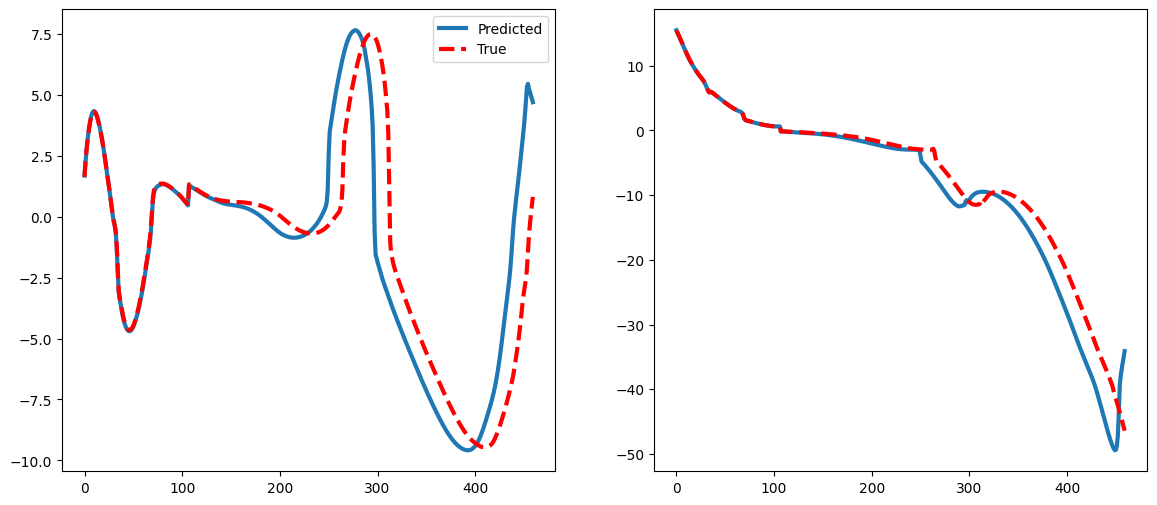

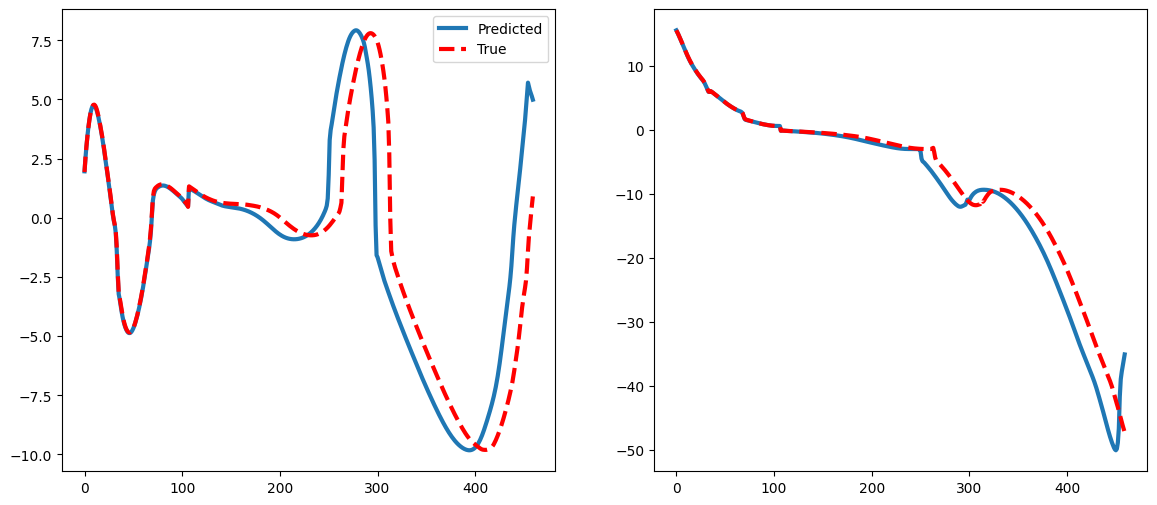

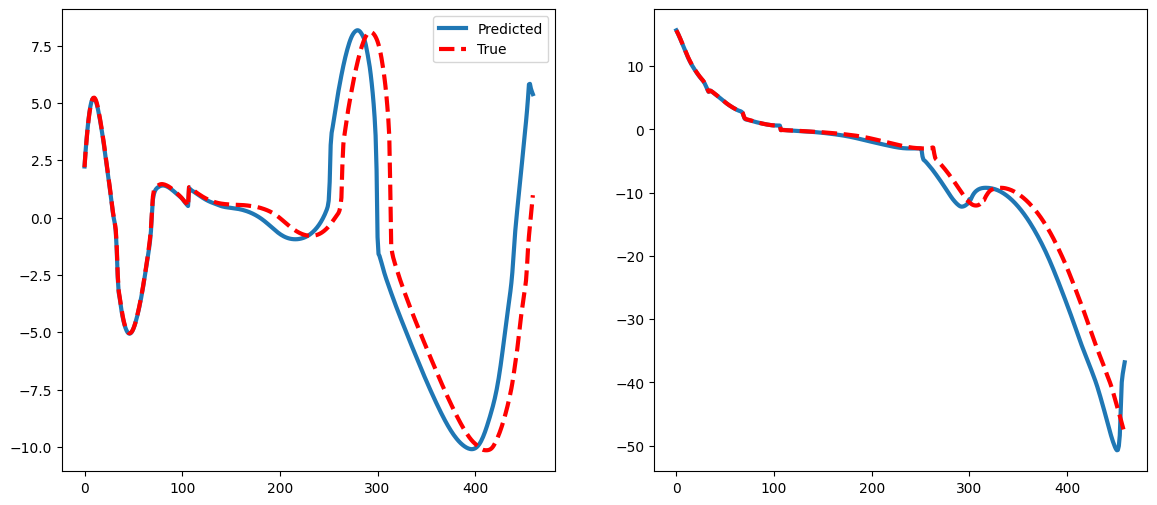

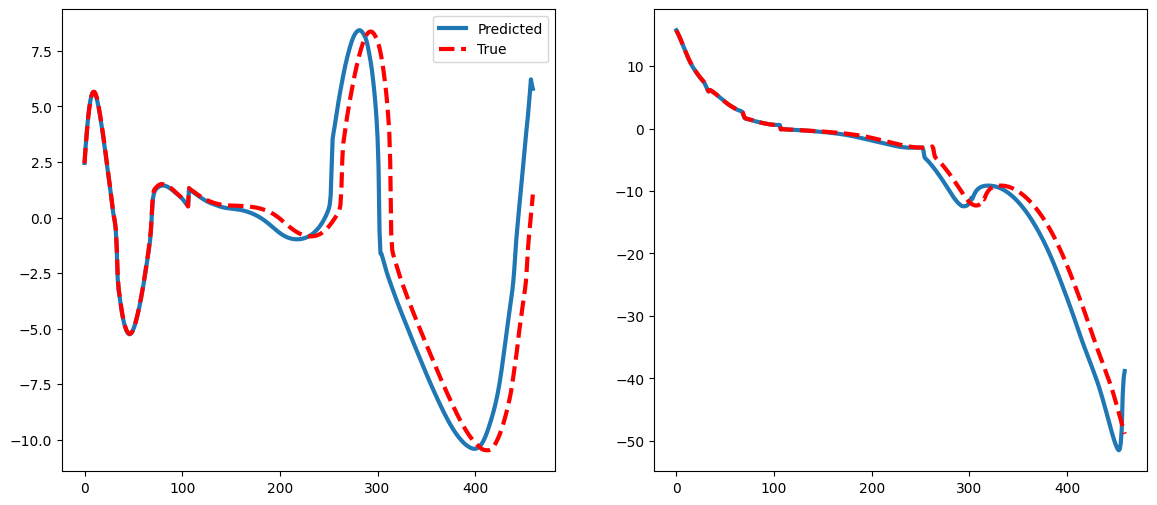

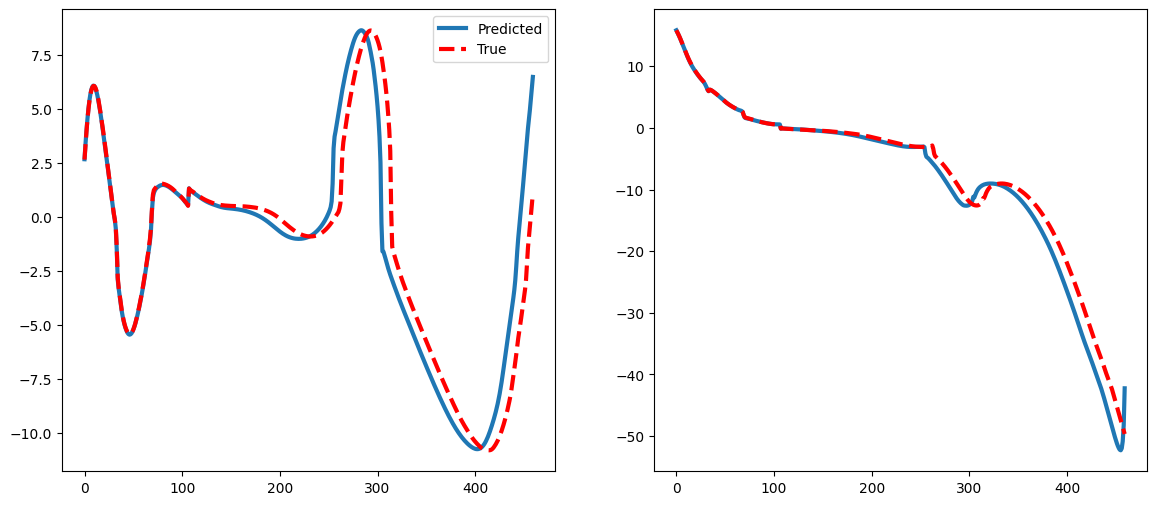

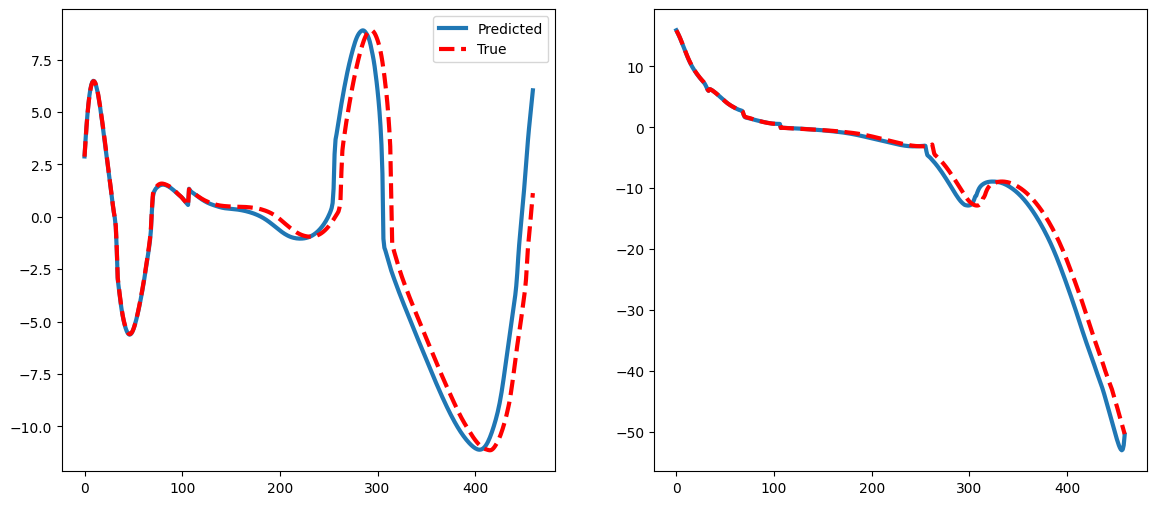

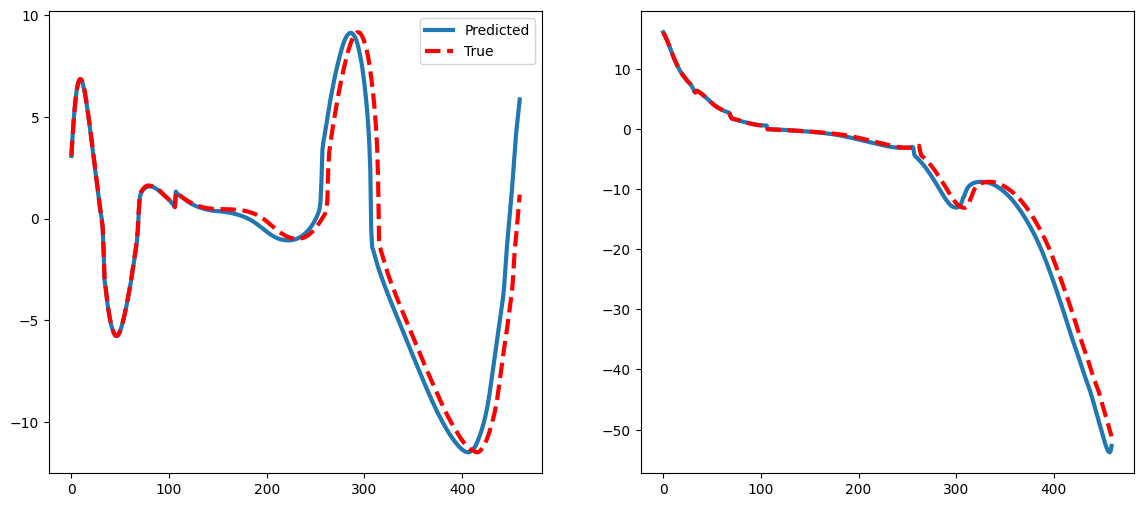

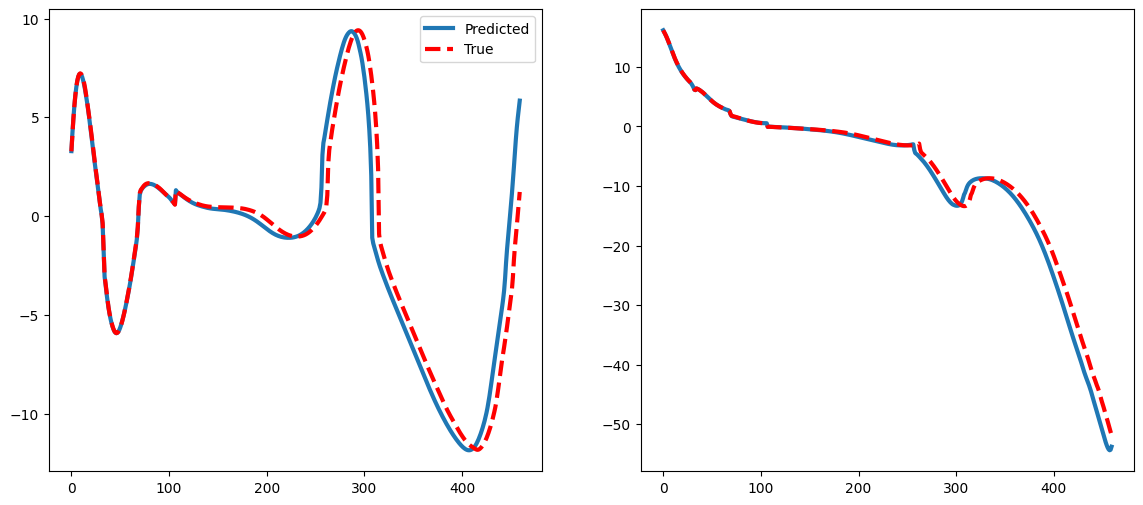

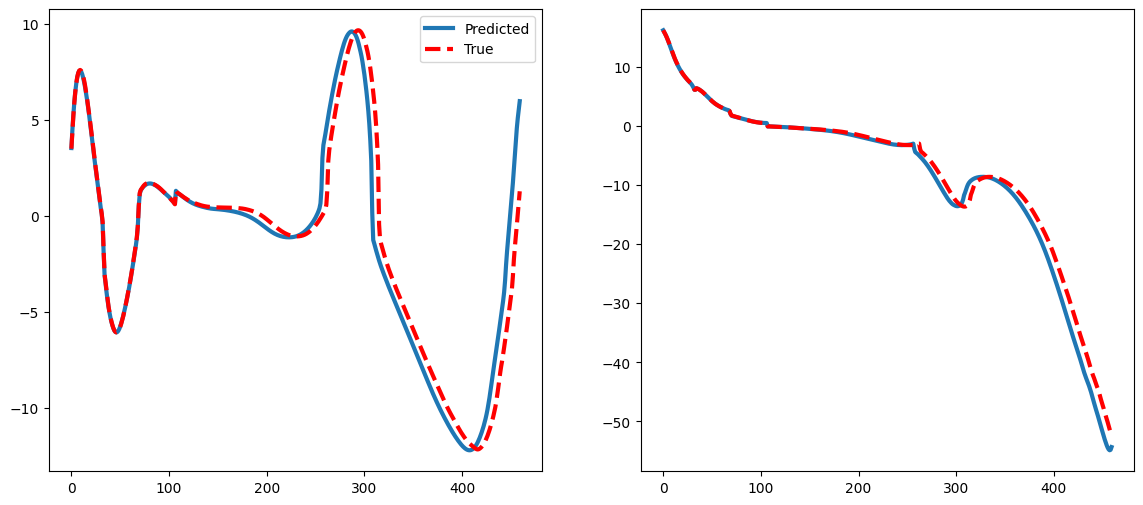

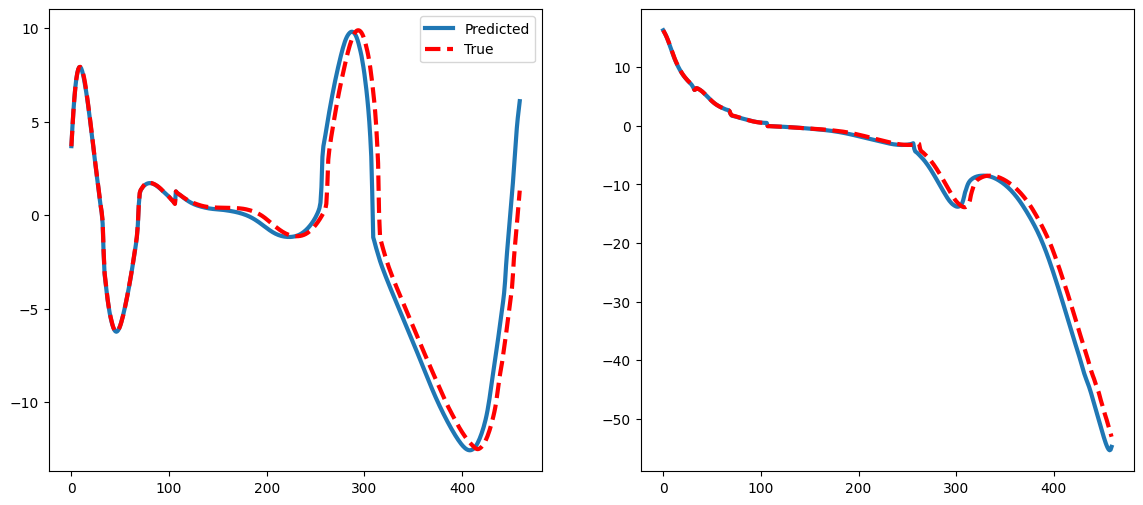

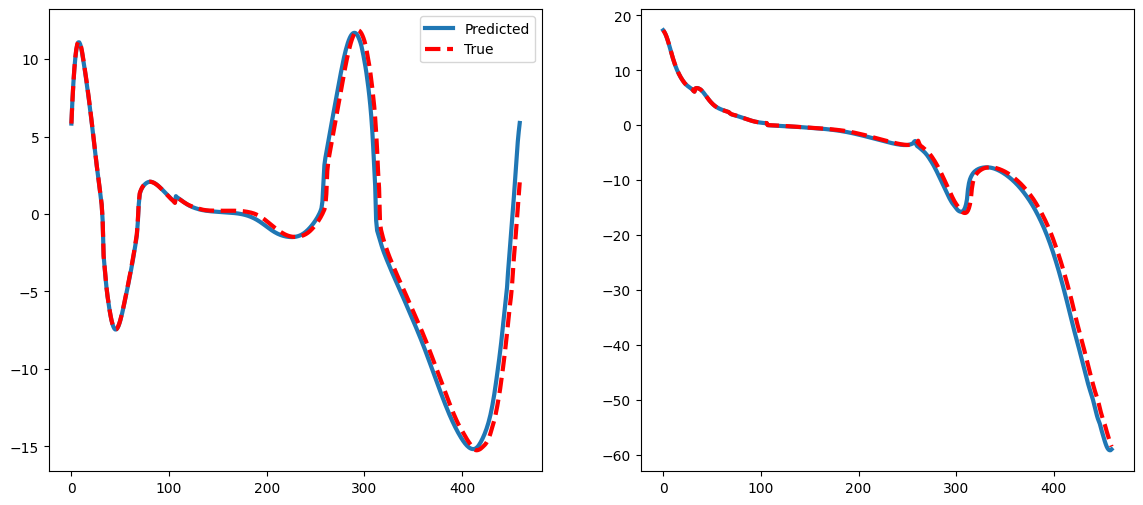

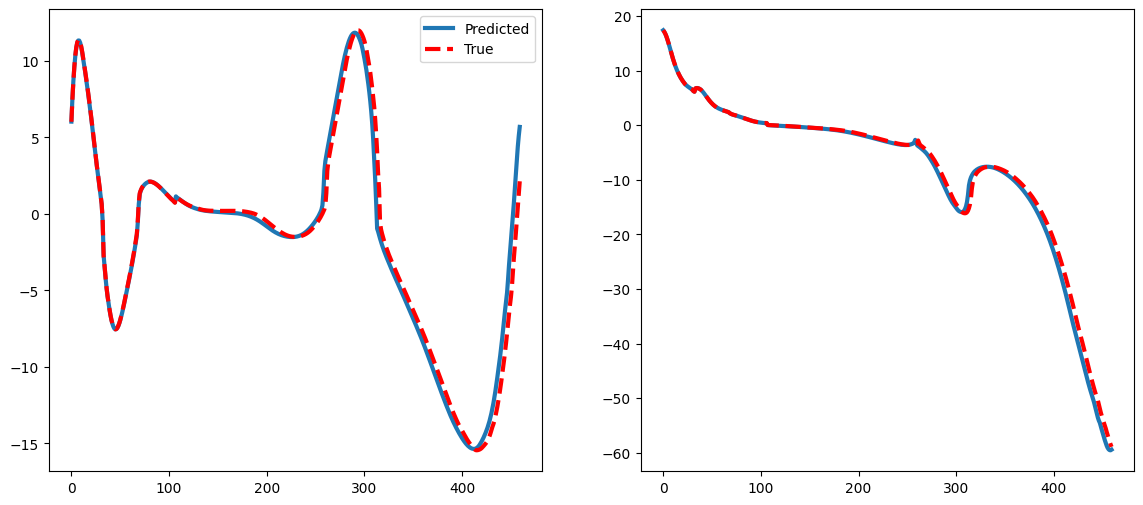

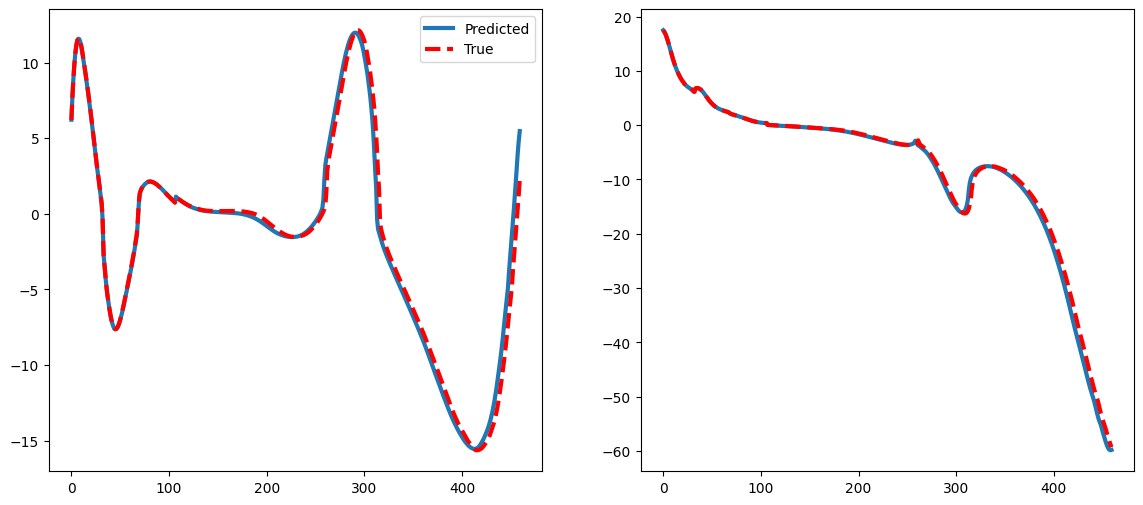

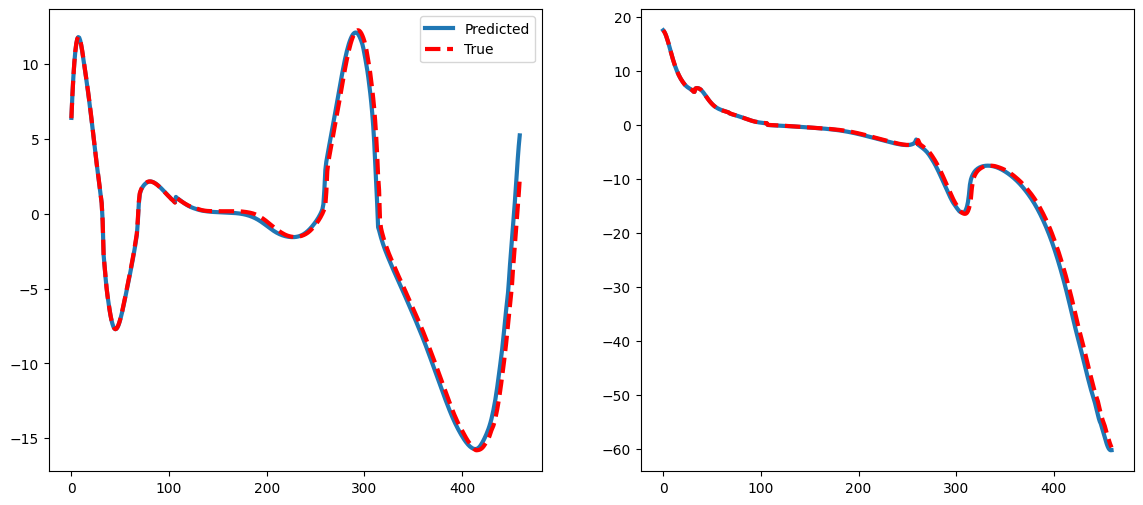

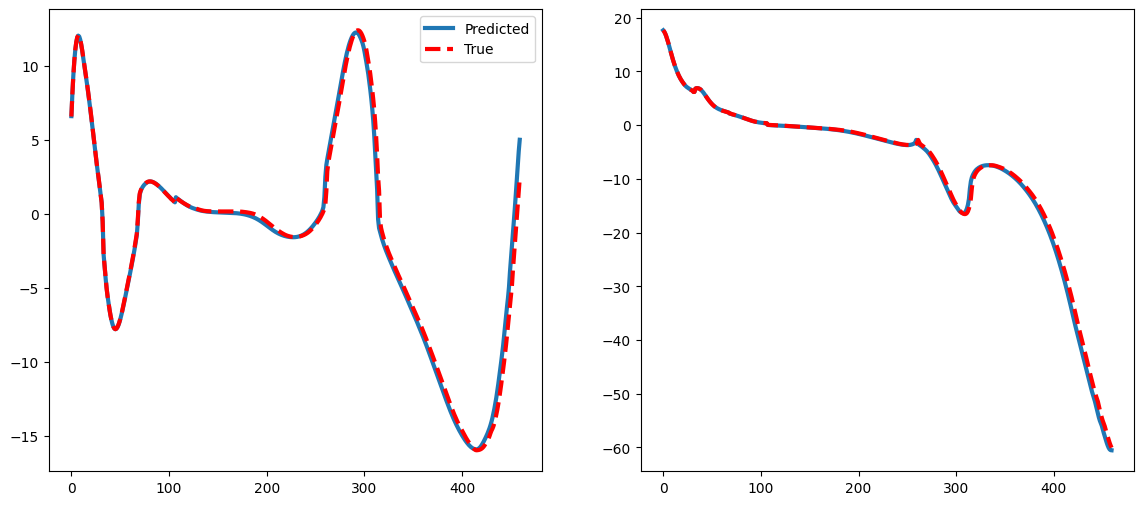

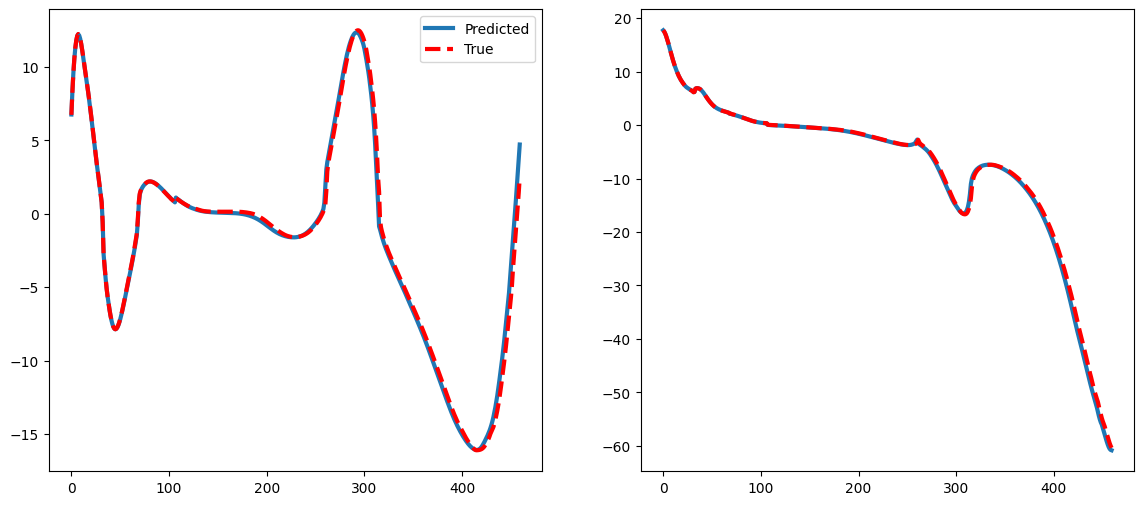

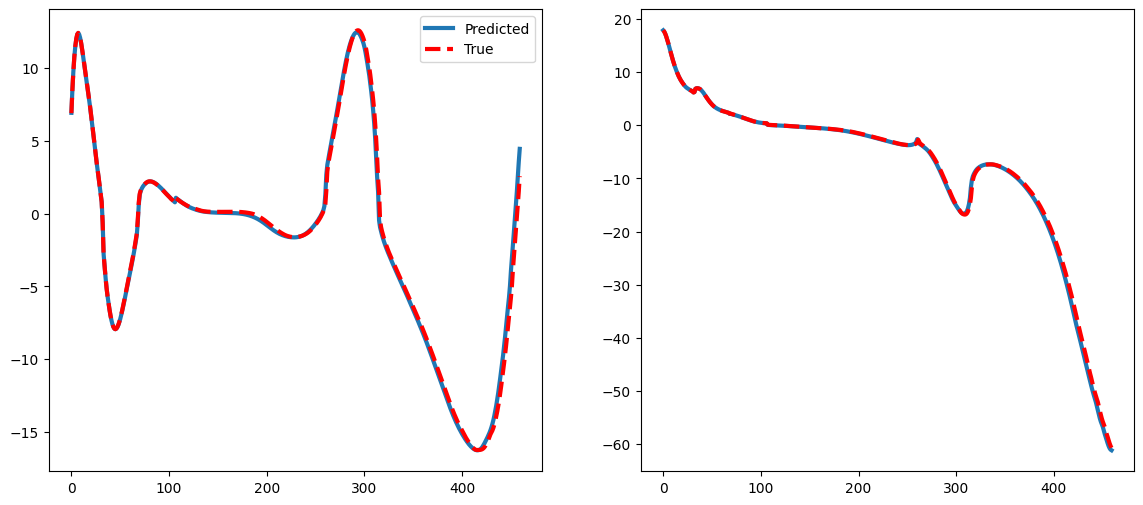

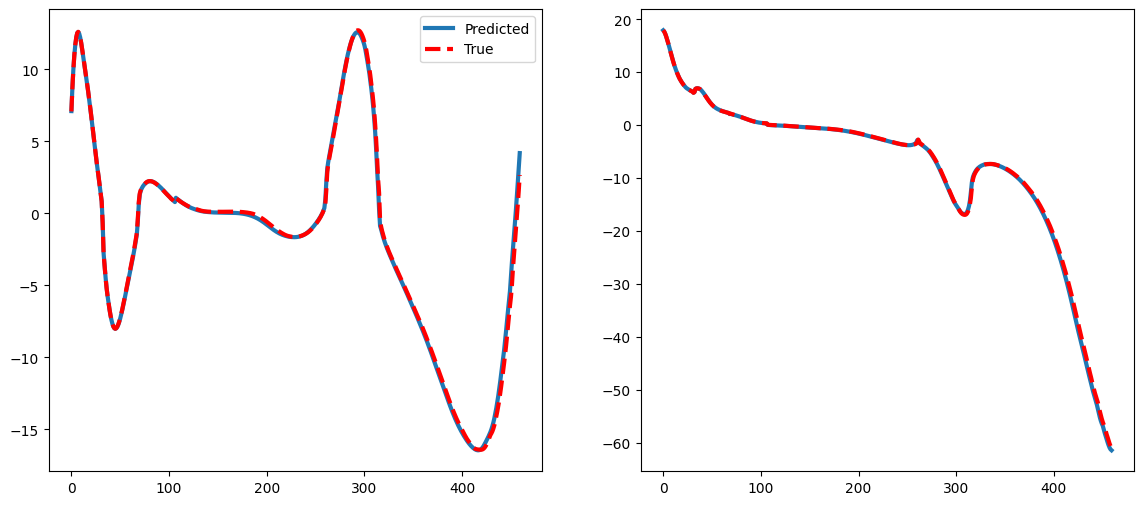

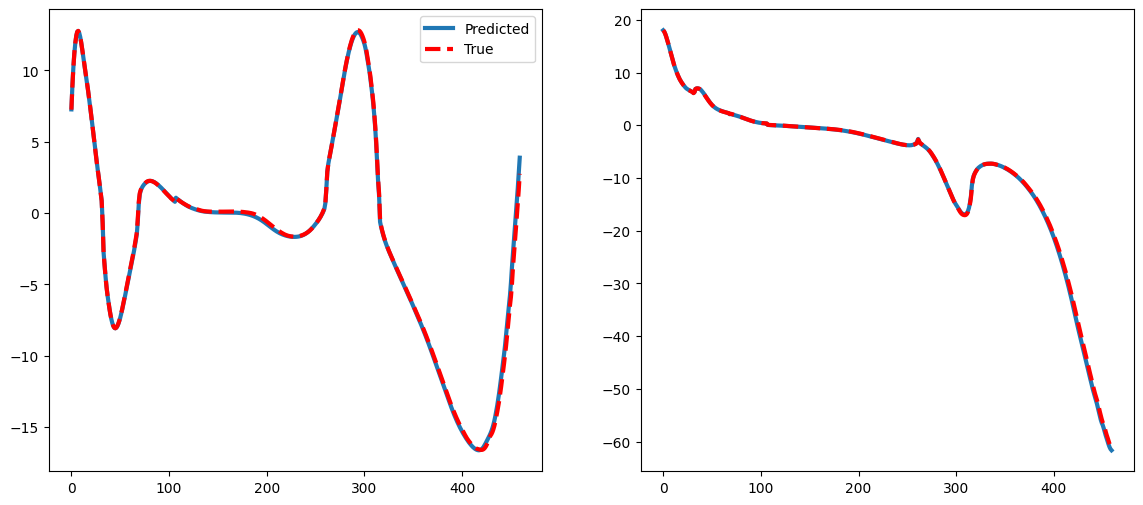

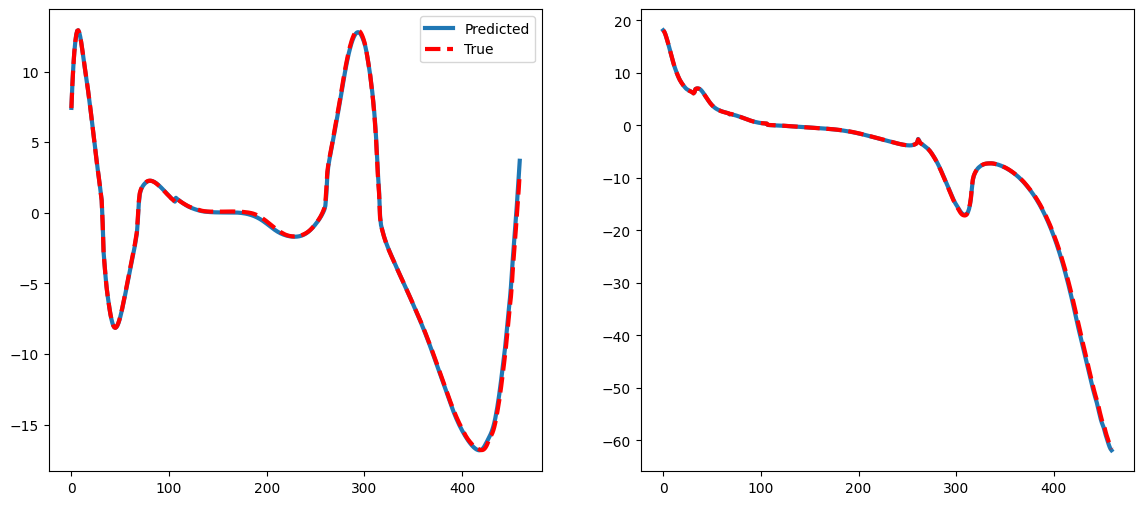

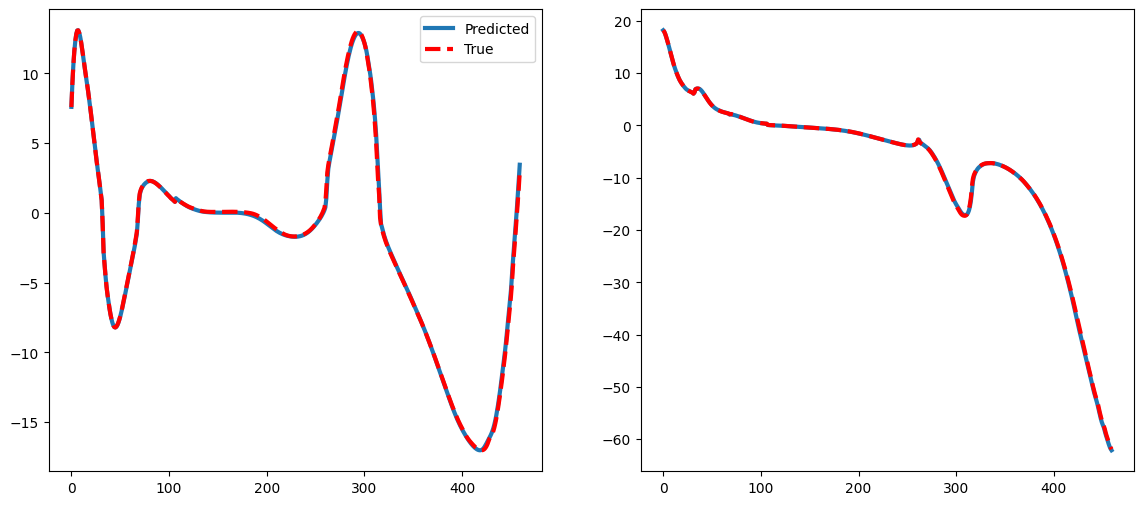

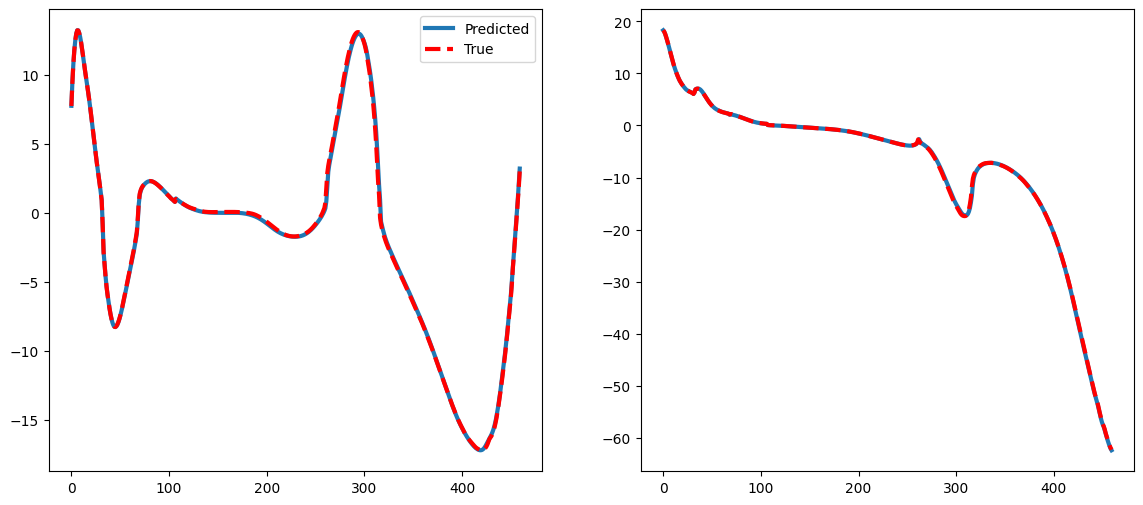

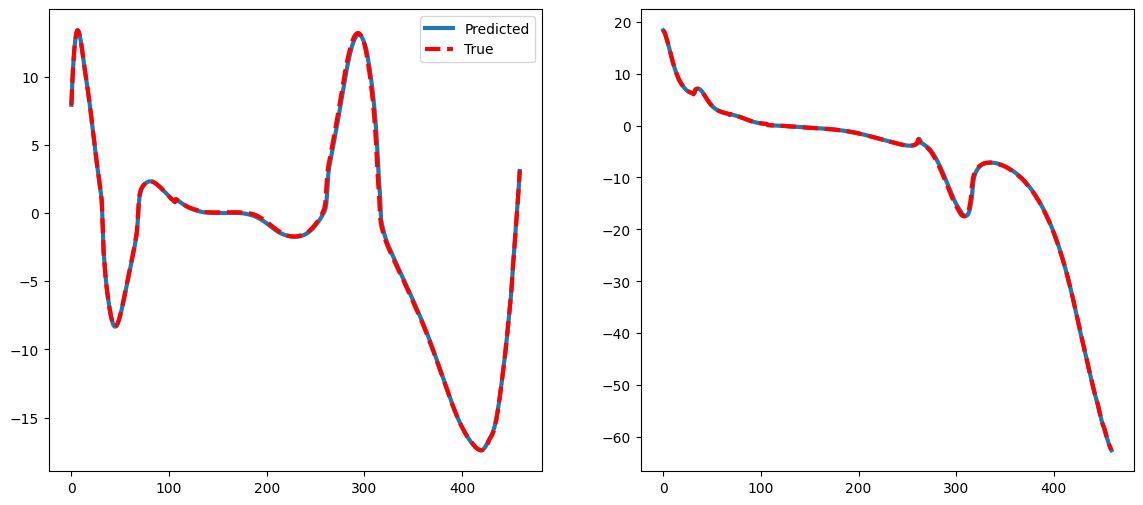

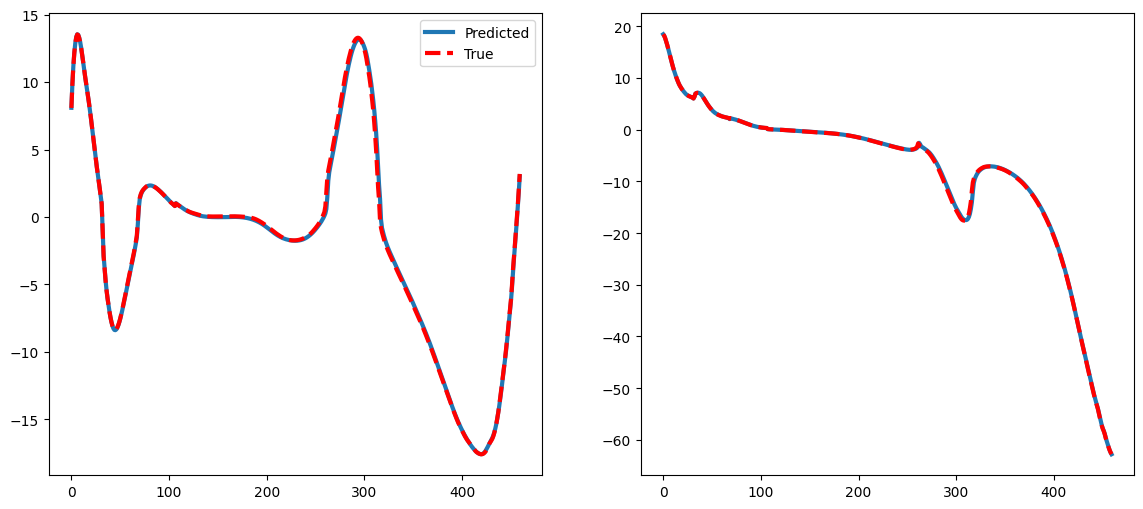

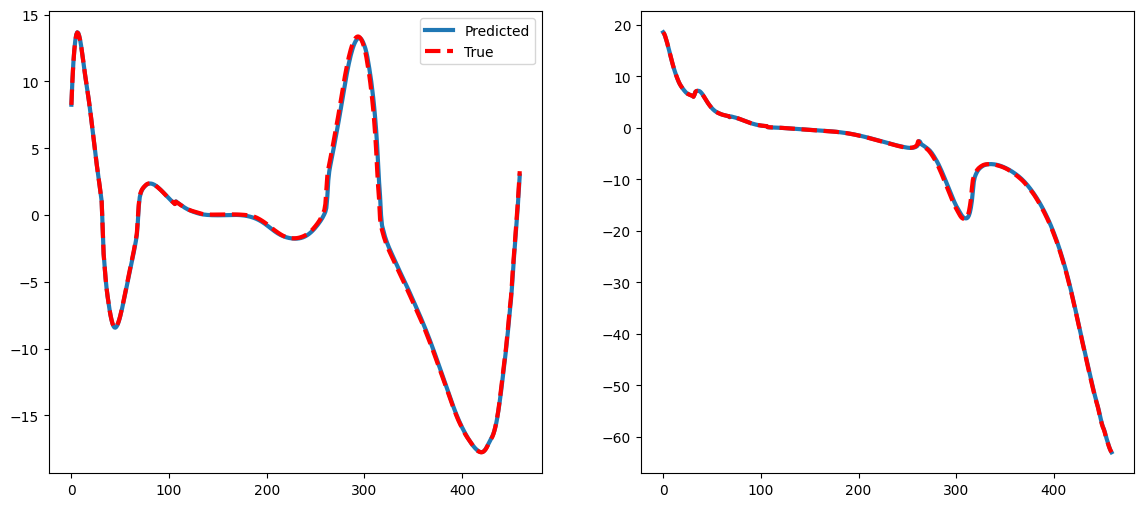

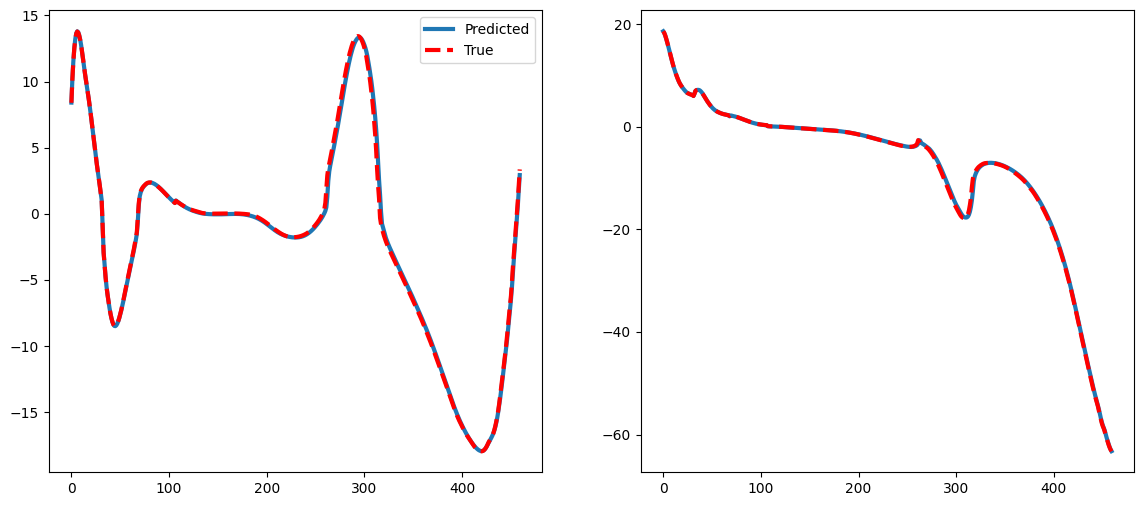

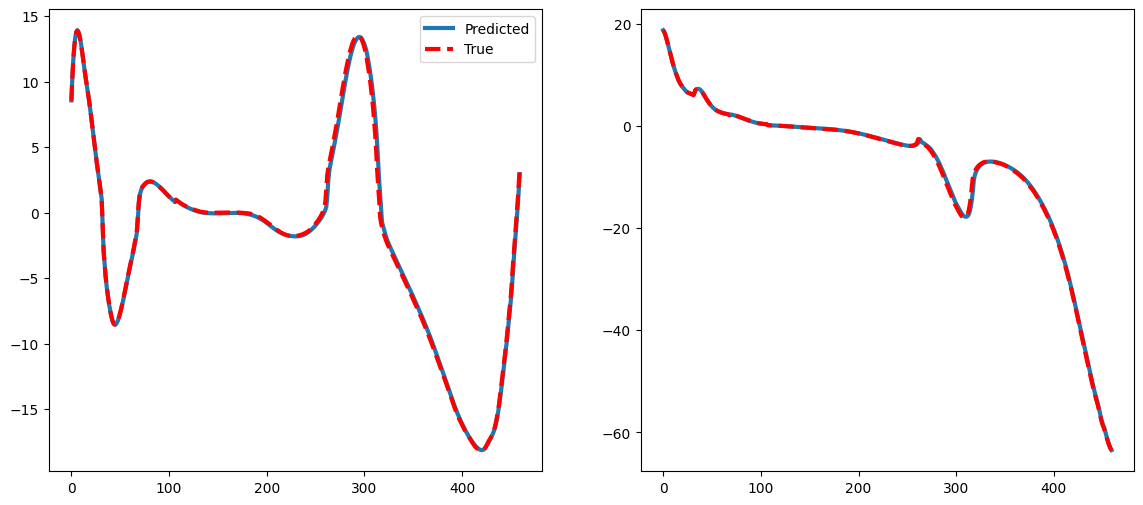

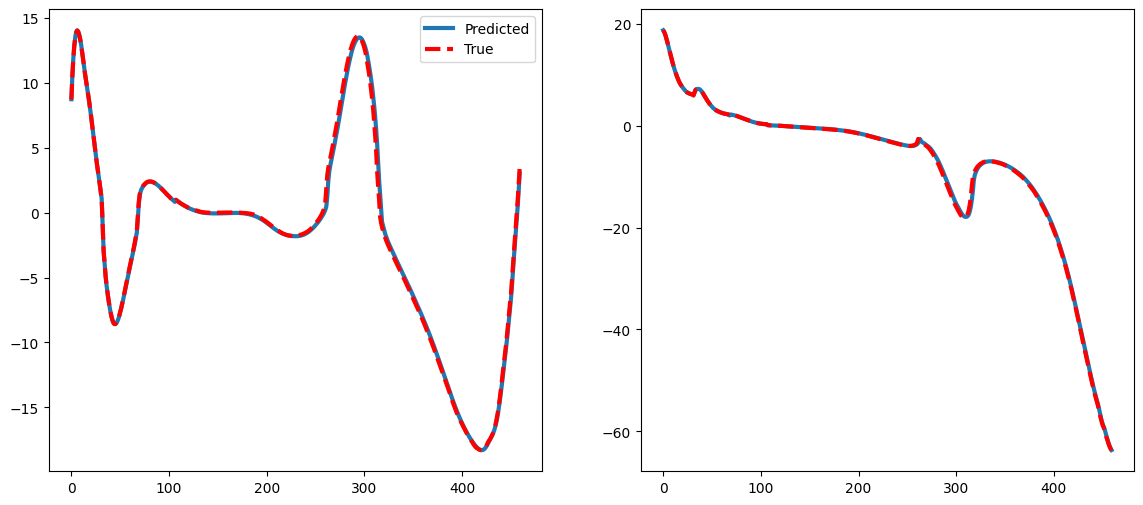

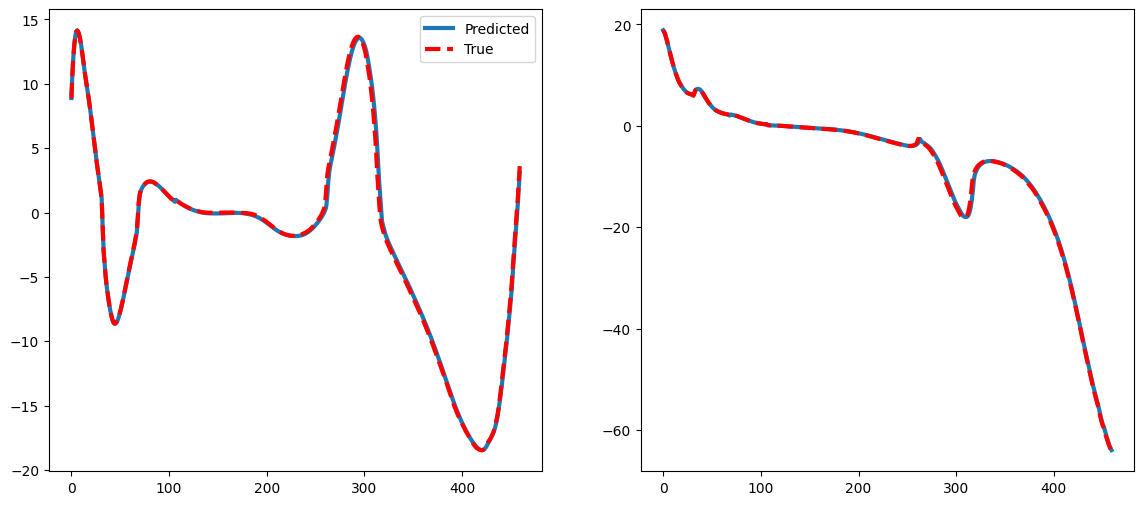

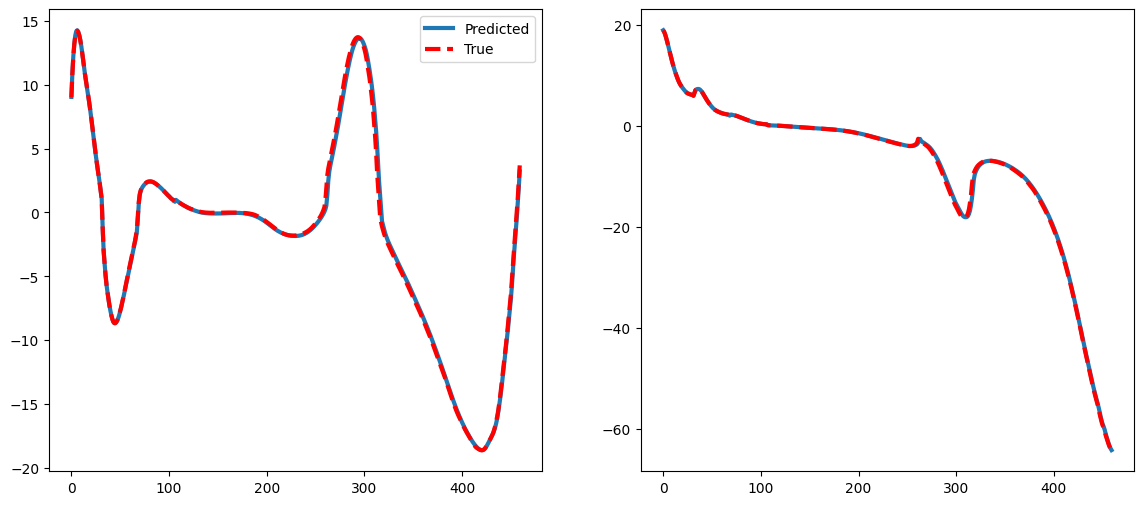

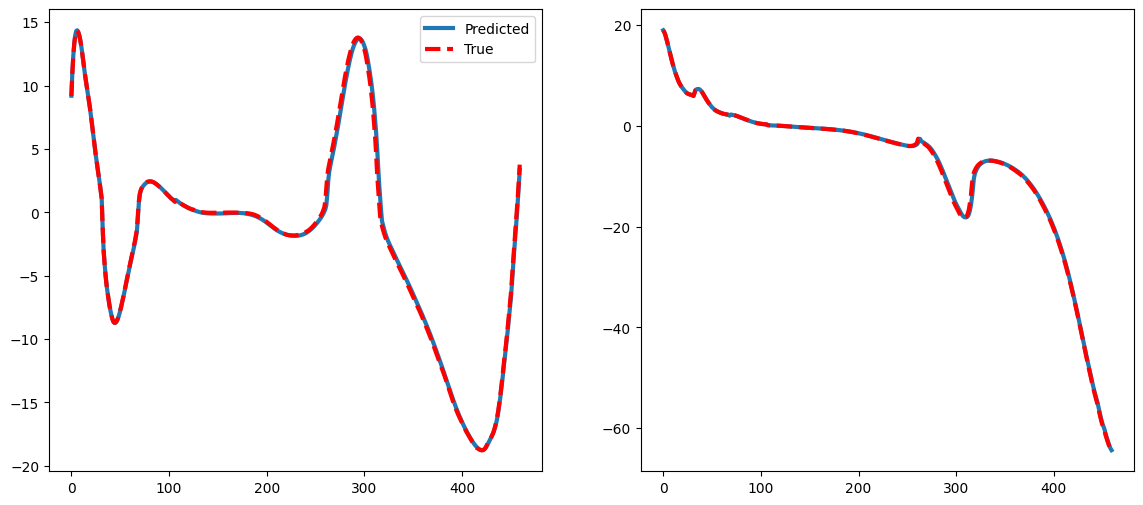

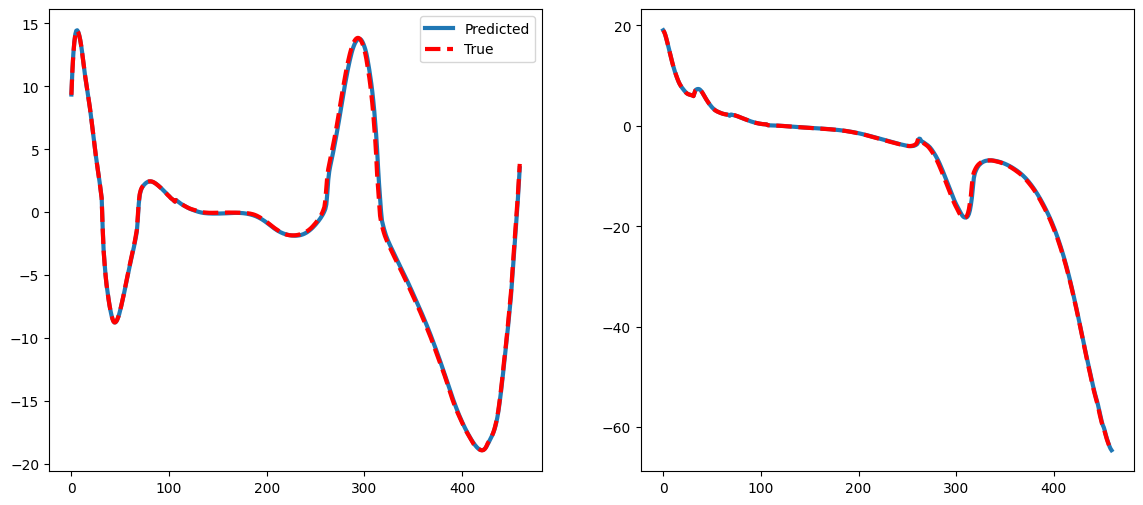

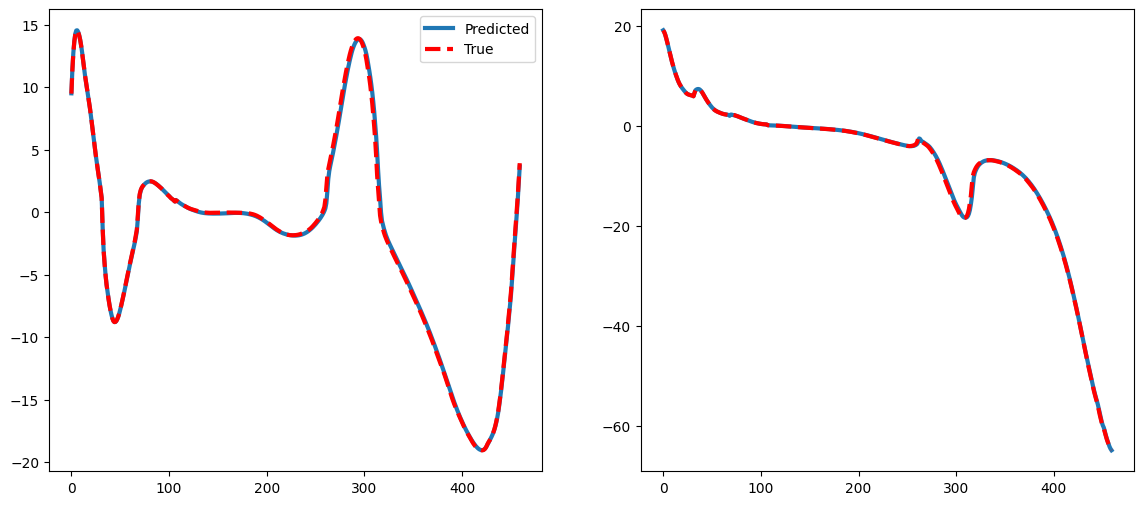

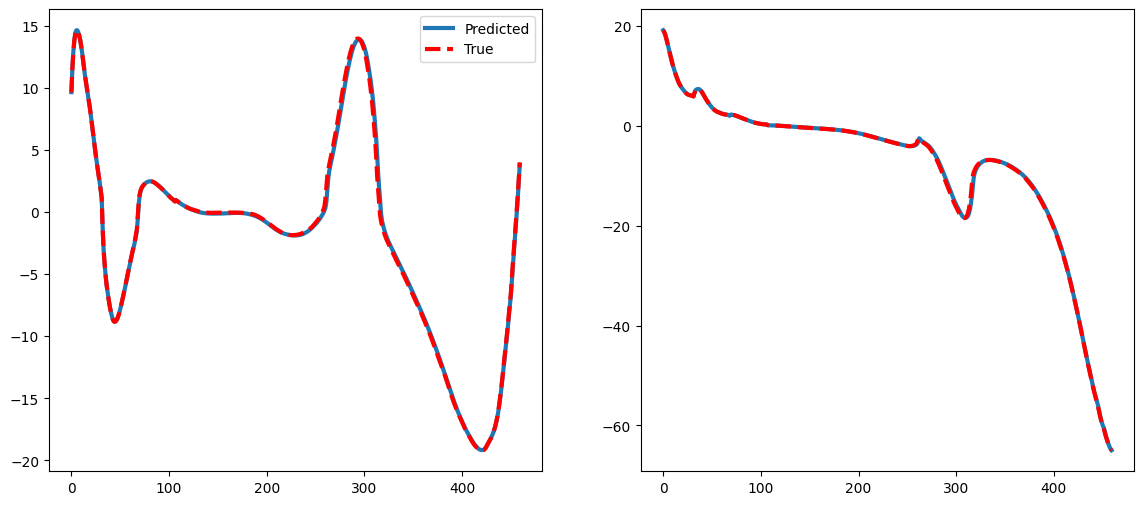

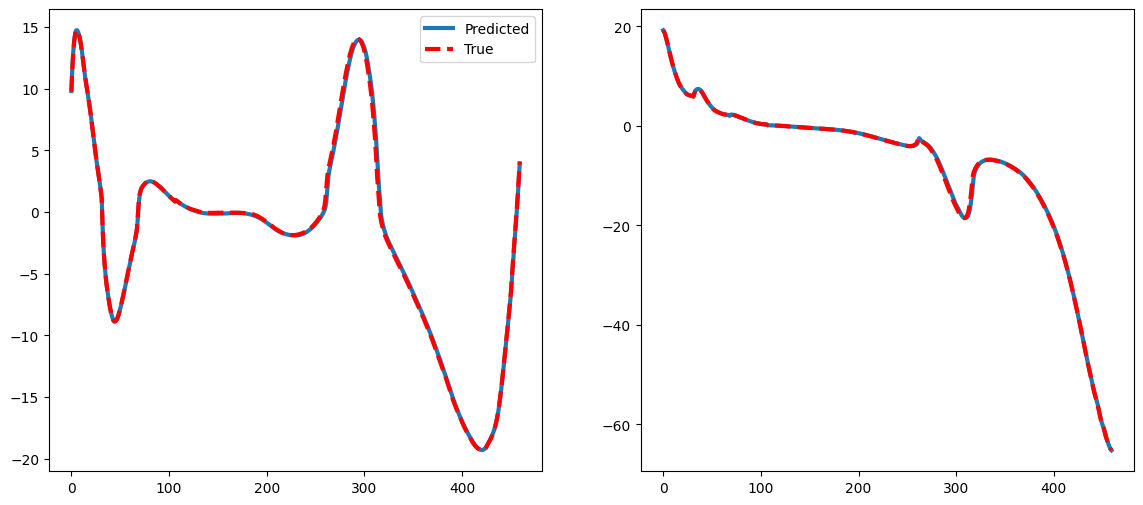

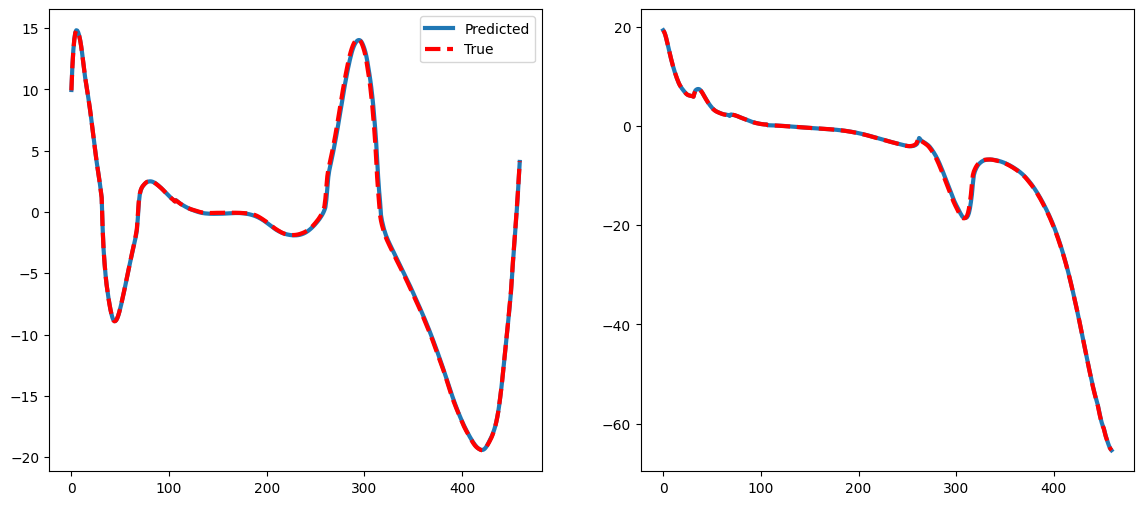

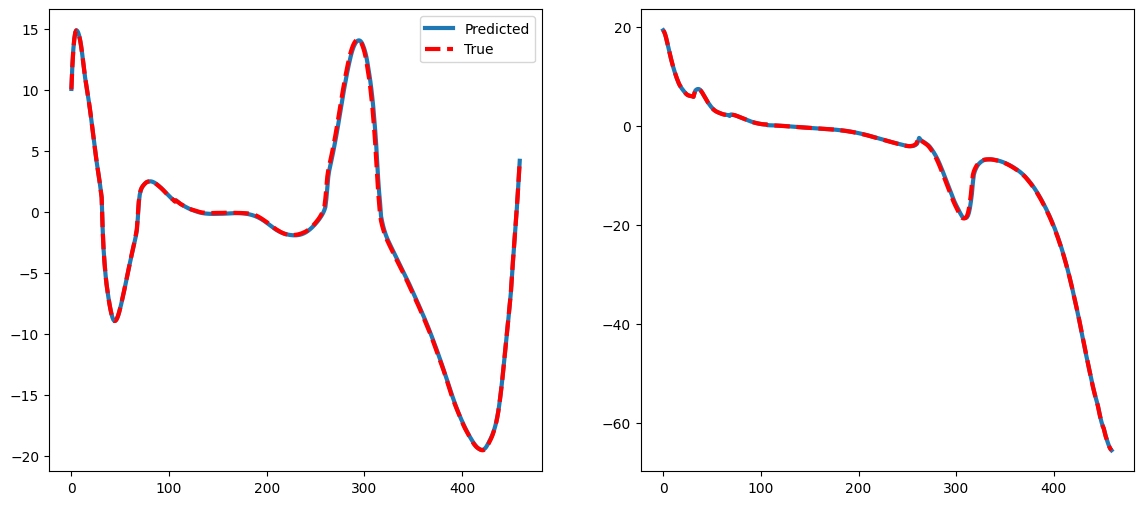

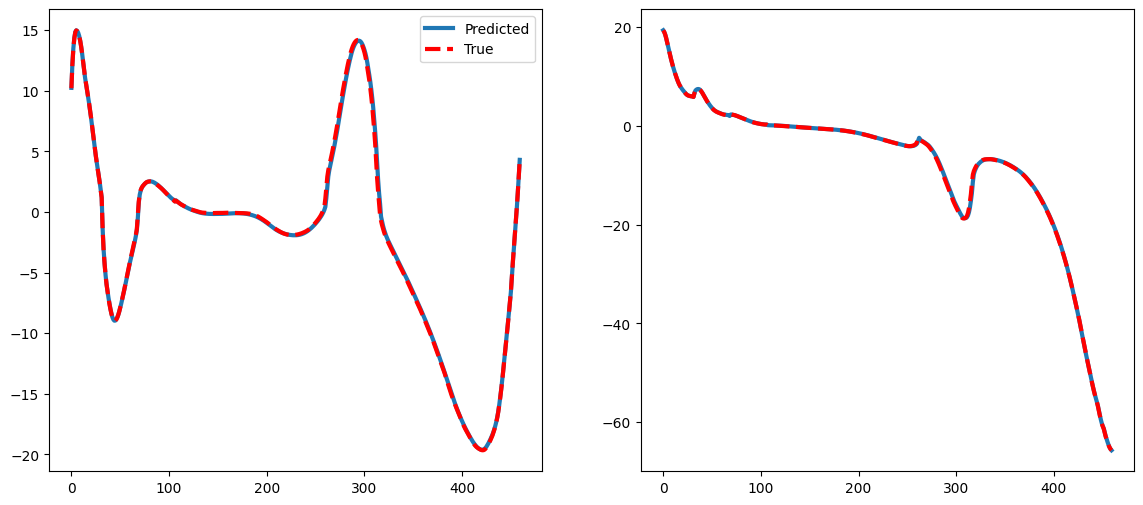

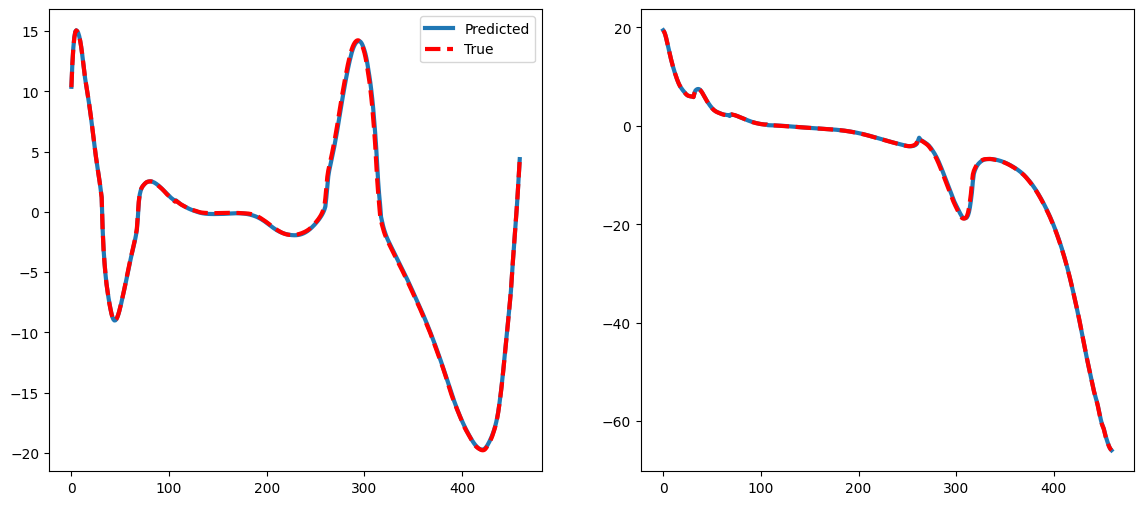

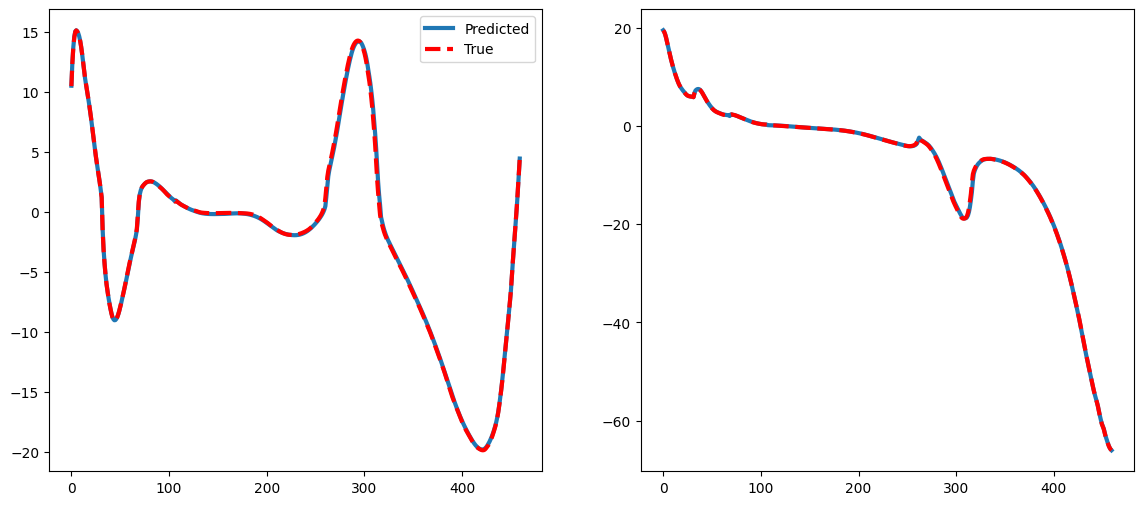

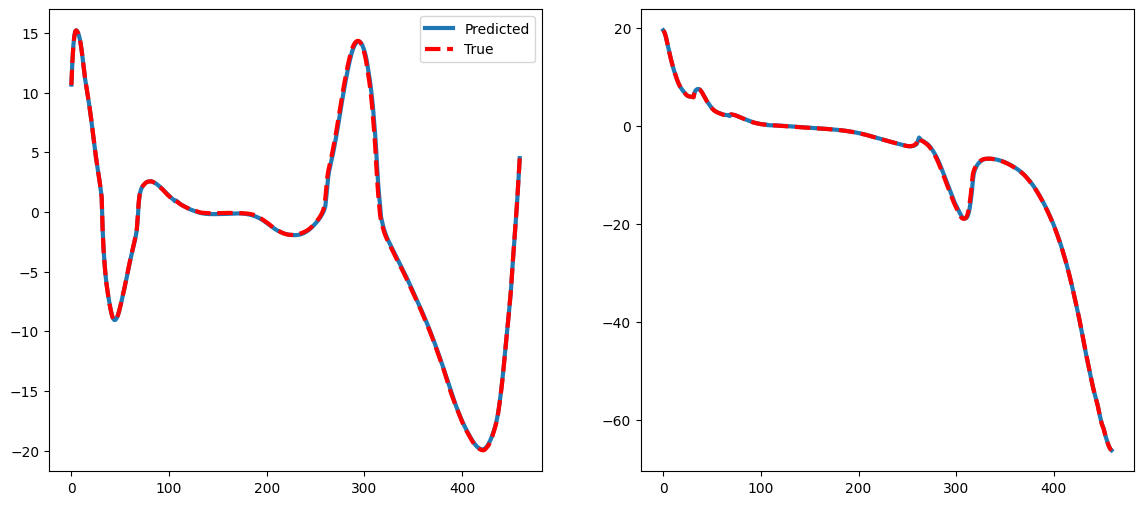

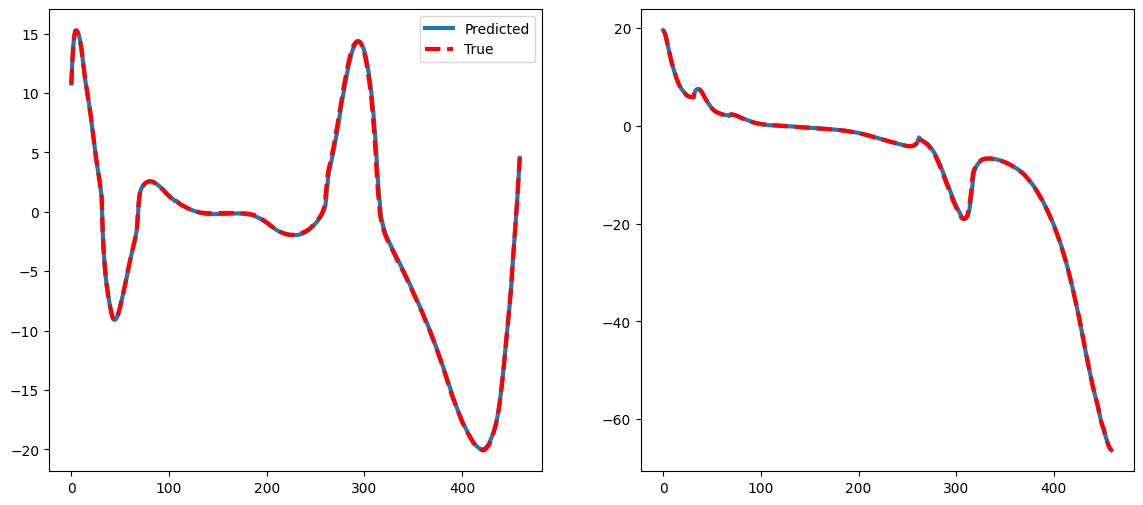

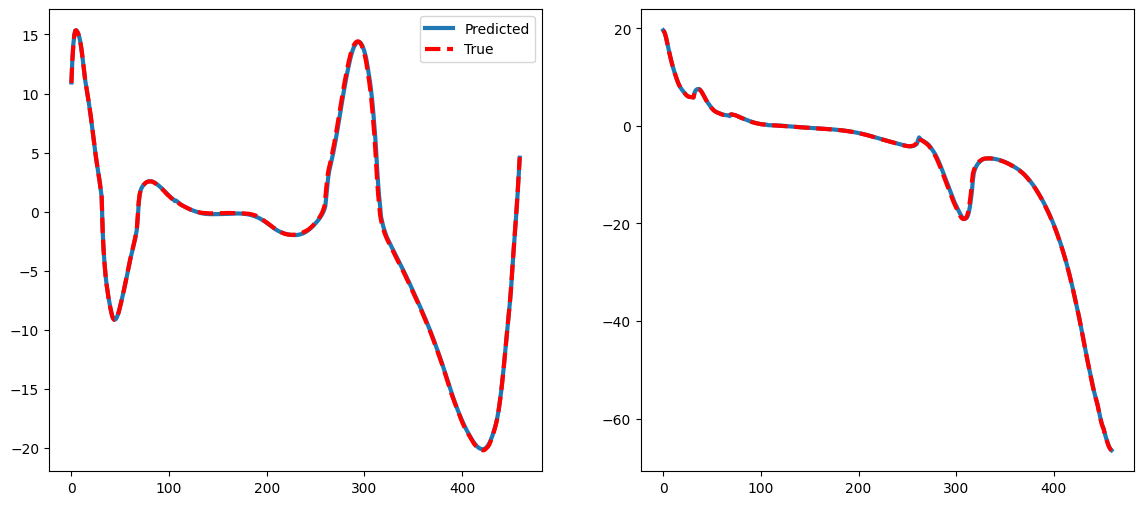

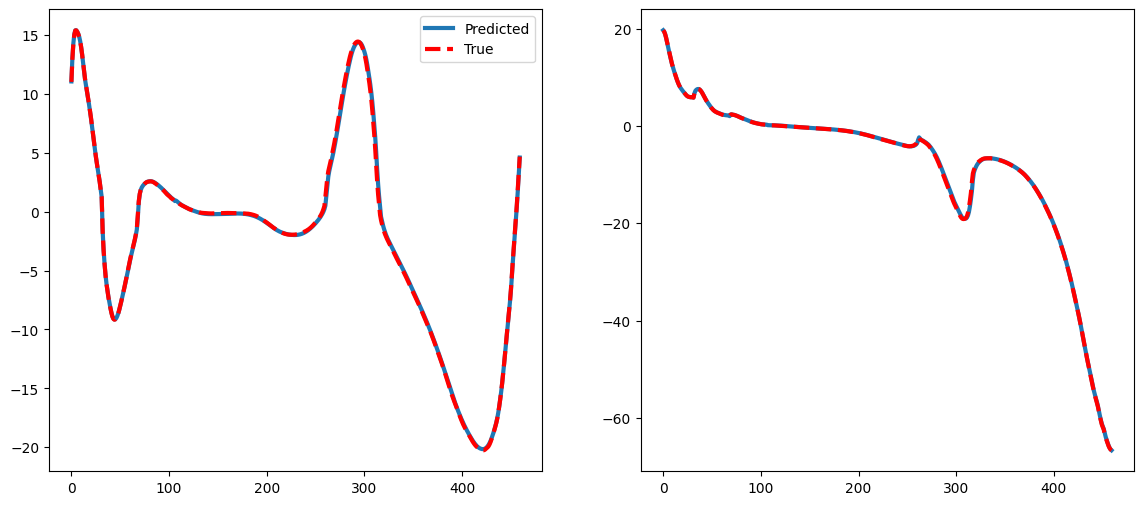

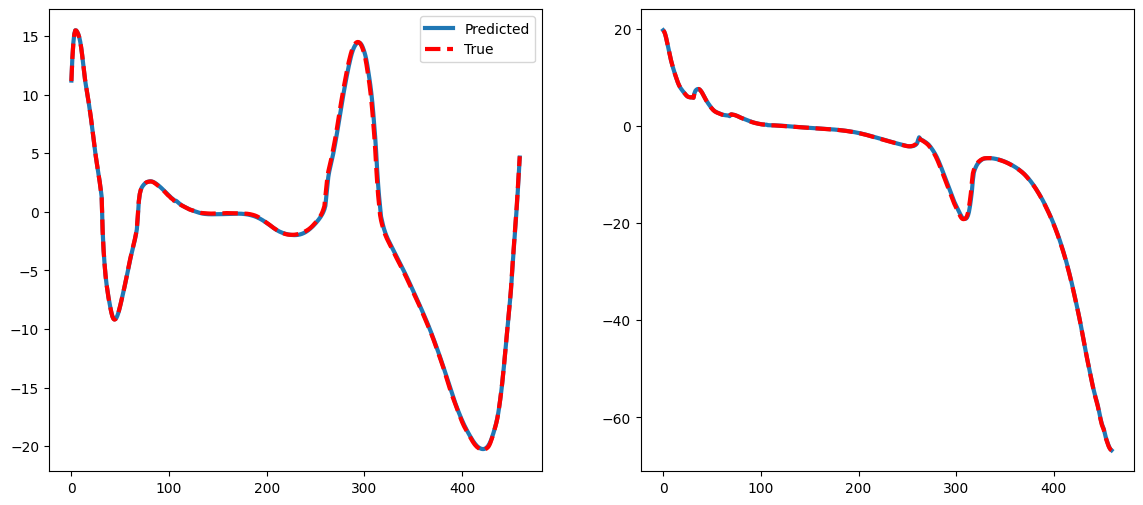

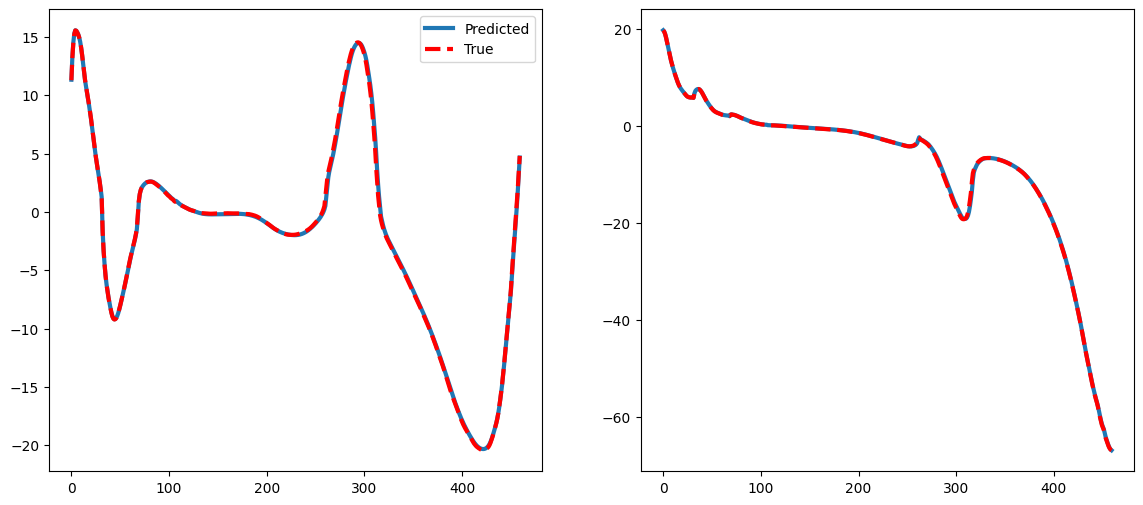

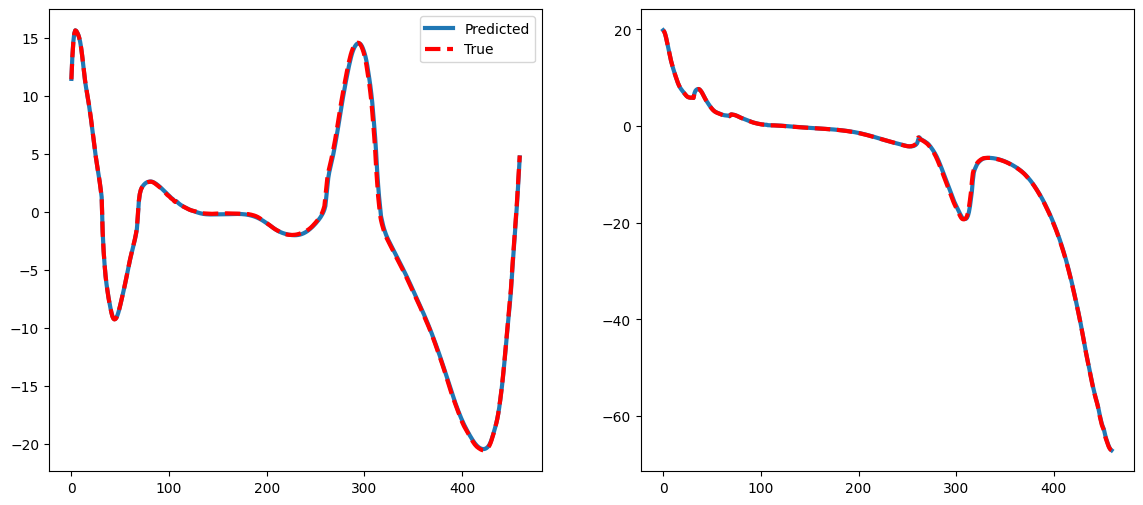

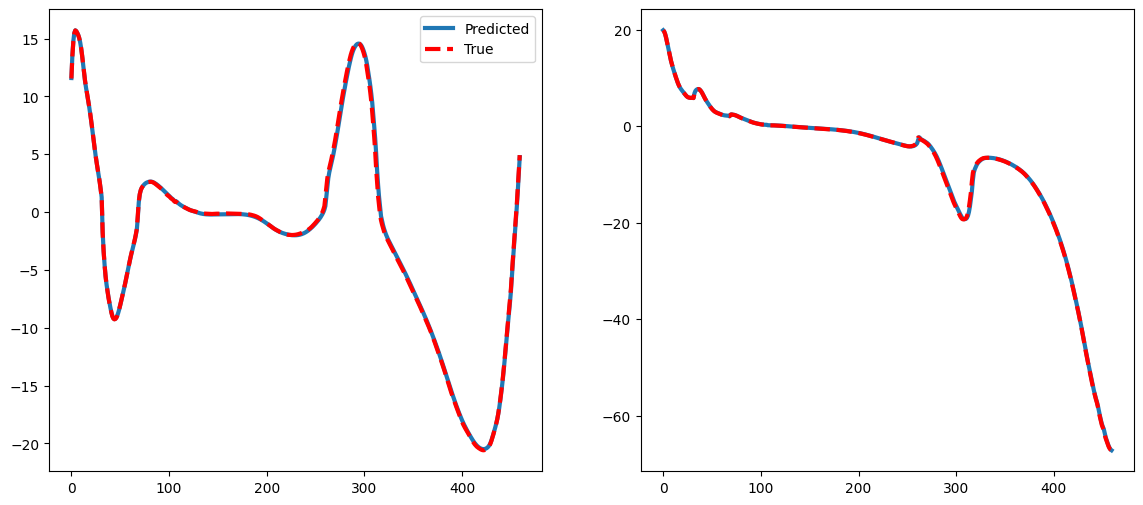

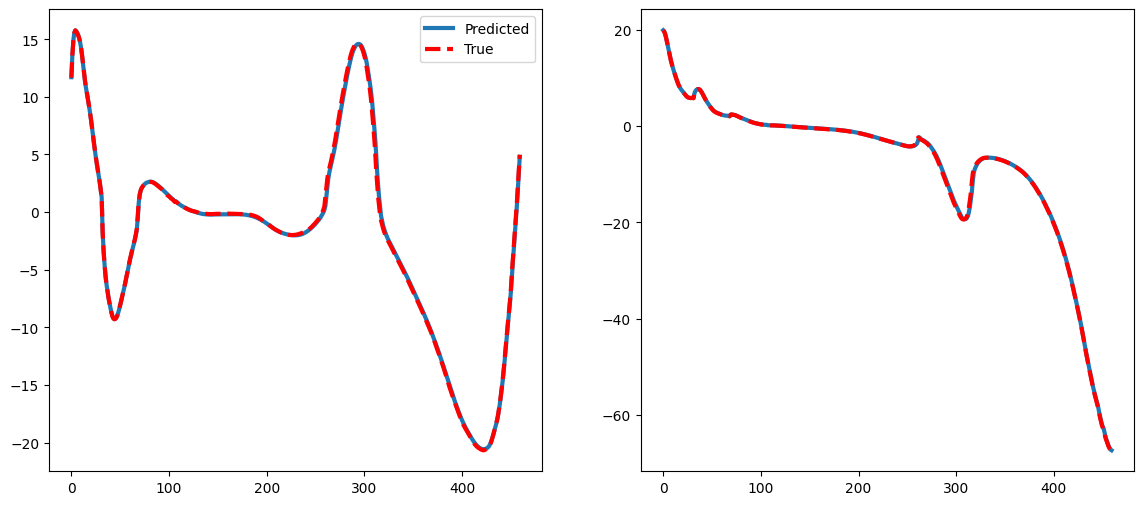

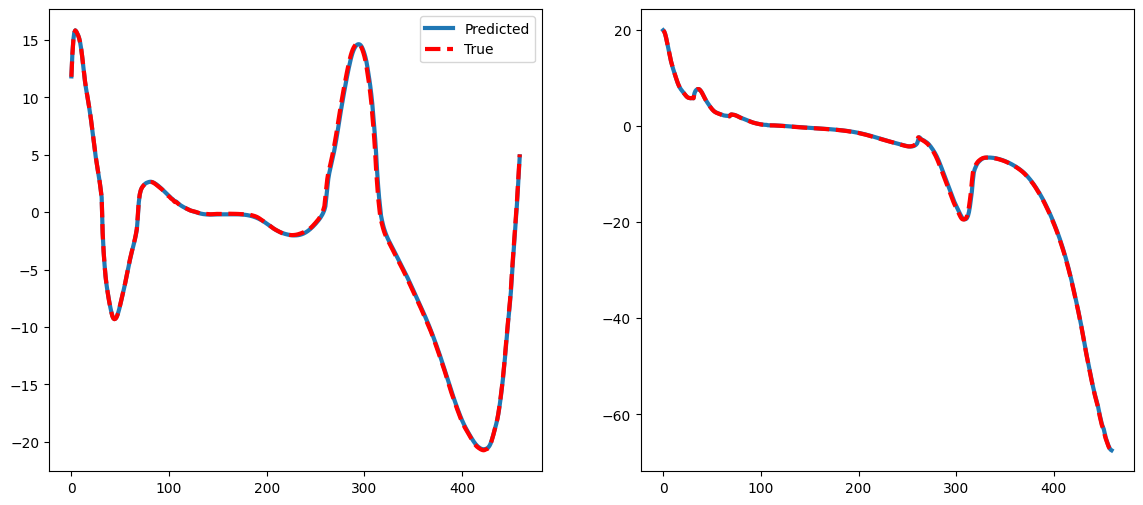

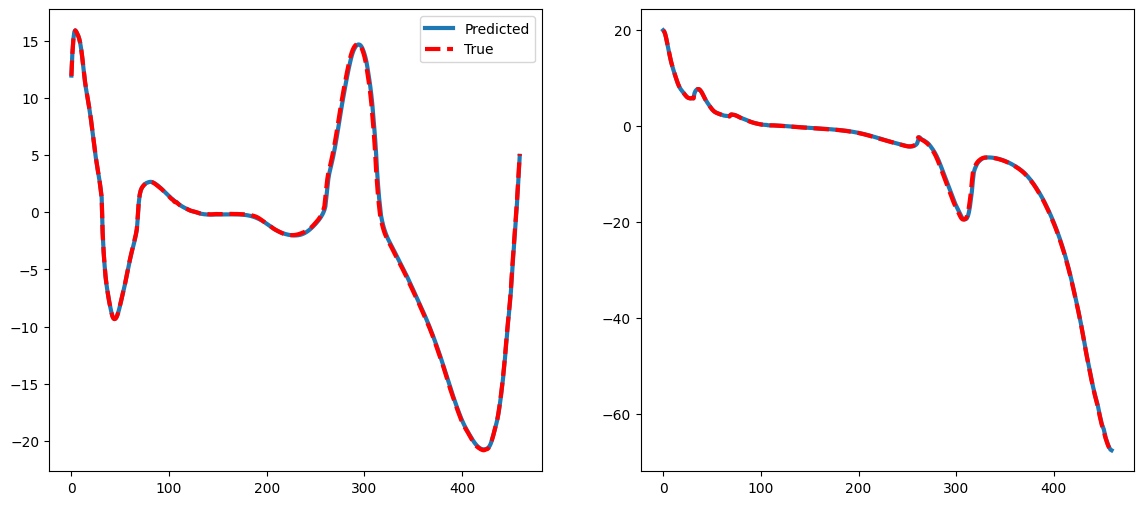

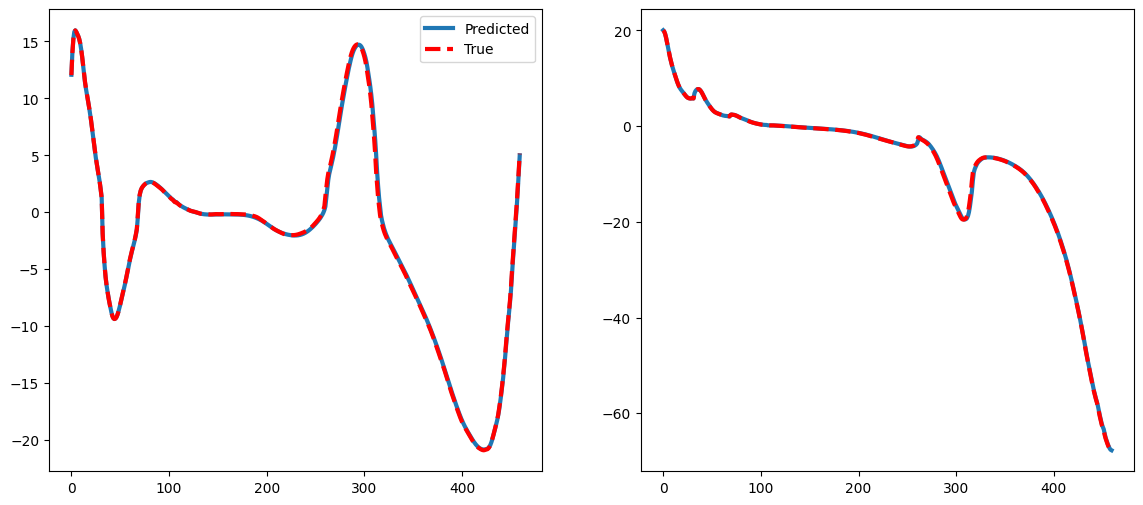

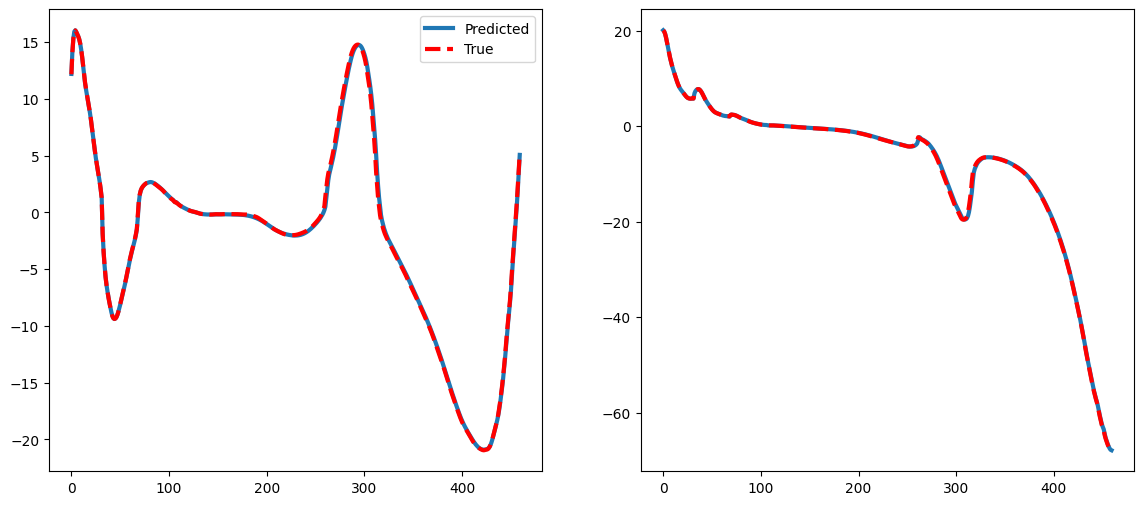

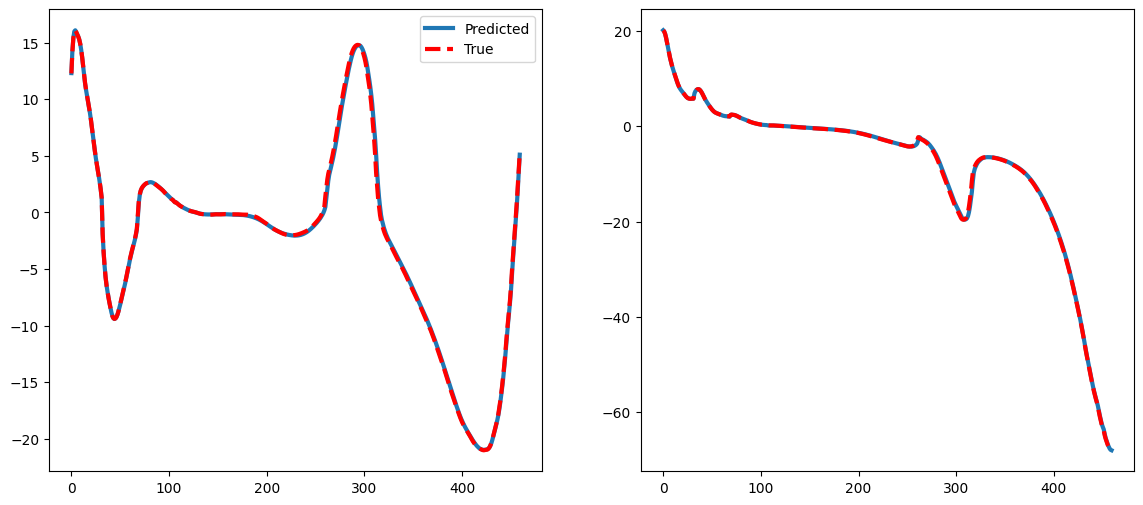

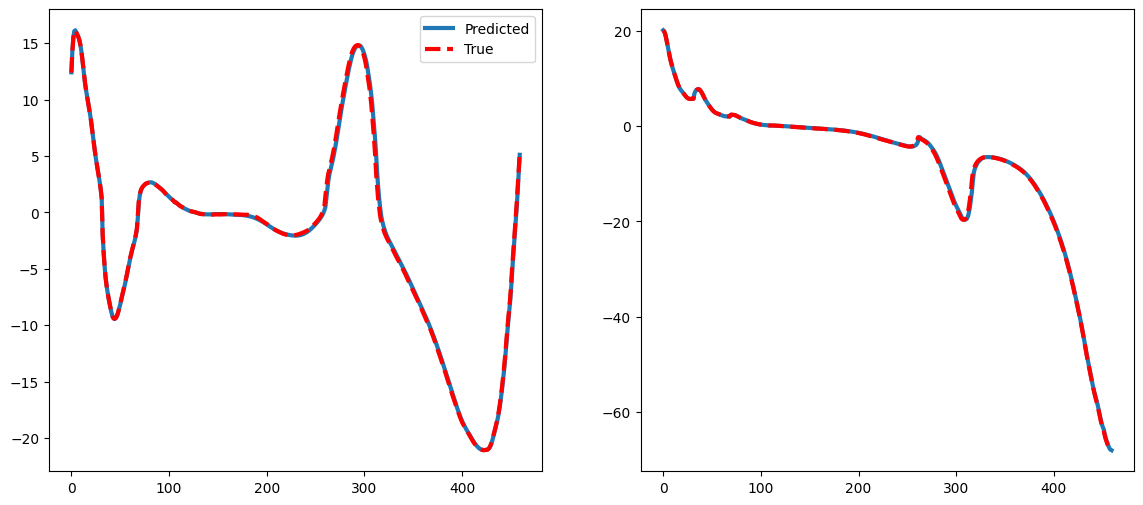

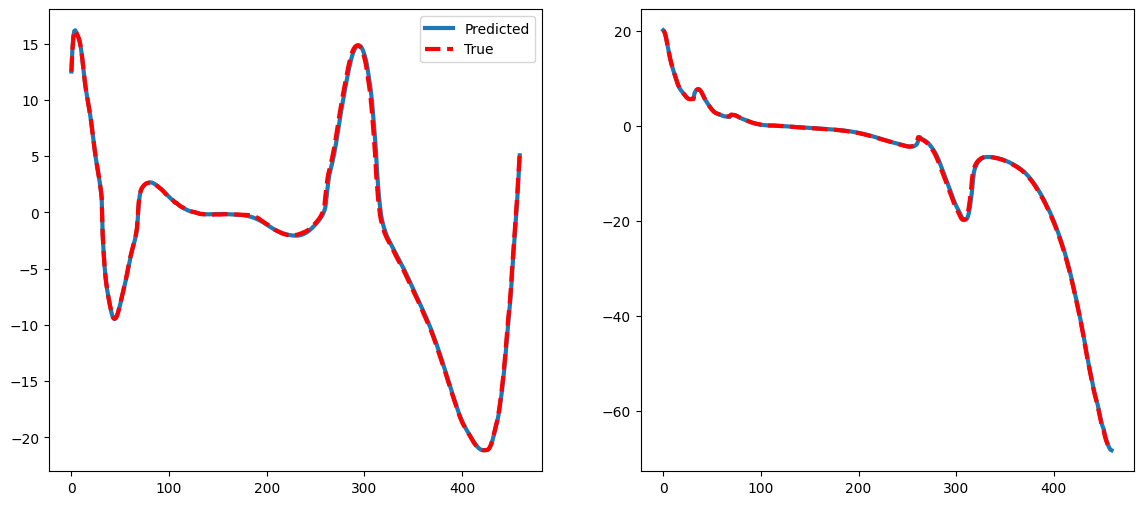

In [37]:
for sim_num in range(num_train_snapshots):
    start_idx = sim_num * (num_time_steps - time_window)
    end_idx   = (sim_num + 1) * (num_time_steps - time_window)

    fig, ax = plt.subplots(figsize=(14,6), nrows=1, ncols=2)

    # For dimension 0
    ax[0].plot(
        output_seq_pred_train[start_idx:end_idx, 0],
        label='Predicted', linewidth=3
    )
    ax[0].plot(
        lstm_training_data[sim_num, time_window:, 0],
        'r--', label='True', linewidth=3
    )

    # For dimension 1
    ax[1].plot(
        output_seq_pred_train[start_idx:end_idx, 1],
        label='Predicted', linewidth=3
    )
    ax[1].plot(
        lstm_training_data[sim_num, time_window:, 1],
        'r--', label='True', linewidth=3
    )

    ax[0].legend()
    plt.show()


## Testing data:

In [38]:
num_test_snapshots, num_time_steps, _ = lstm_testing_data.shape

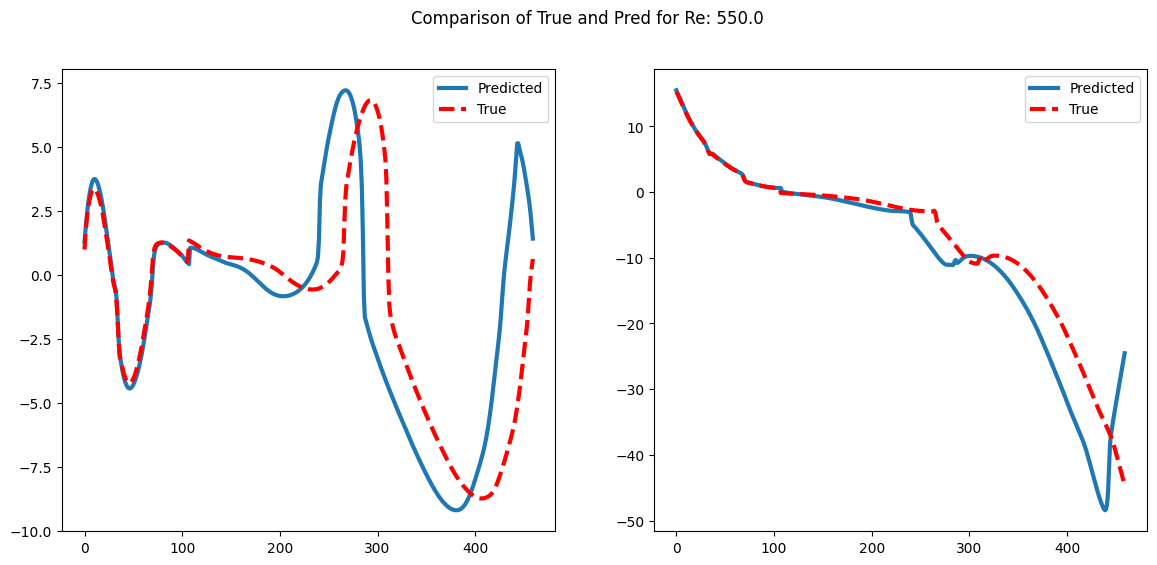

In [39]:
sim_num = 0
time_window = 40
num_time_steps = 500

# We'll do 90 predictions after the initial 10
samples_to_predict = num_time_steps - time_window  # 90

# ---------------------------
# 2) Prepare a rolling buffer & arrays to store predictions
# ---------------------------
input_seq = np.zeros((1, time_window, 3), dtype=np.float32)
predictions = np.zeros((samples_to_predict, 2), dtype=np.float32)
y_true = np.zeros((samples_to_predict, 2), dtype=np.float32)

# Initialize the first 10 steps from the data
input_seq[0, :, :] = lstm_testing_data[sim_num, 0:time_window, :]

# ---------------------------
# 3) Autoregressive loop
# ---------------------------
sample = 0
lstm_model.eval()  # ensure we're in inference mode, no dropout etc.

with torch.no_grad():
    for t in range(time_window, num_time_steps):  # from 10..99
        # Convert to PyTorch tensor
        inp_tensor = torch.from_numpy(input_seq).float()  # shape [1, 10, 3]
        
        # Forward pass
        pred = lstm_model(inp_tensor)               # shape [1, 2]
        pred_np = pred.numpy()[0, :]           # shape [2,]
        
        # Store prediction & ground truth
        predictions[sample, :] = pred_np
        y_true[sample, :] = lstm_testing_data[sim_num, t, 0:2]  # Fix here
        
        # Shift the rolling window by 1
        temp = input_seq[0, 1:time_window, :].copy()
        input_seq[0, 0:time_window-1, :] = temp
        input_seq[0, time_window-1, 0:2] = pred_np
        
        sample += 1

# ---------------------------
# 4) Plot predictions vs. ground truth
# ---------------------------
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot the first latent dimension
ax[0].plot(predictions[:, 0], label='Predicted', linewidth=3)
ax[0].plot(lstm_testing_data[sim_num, time_window:, 0], 'r--', label='True', linewidth=3)
ax[0].legend()

# Plot the second latent dimension
ax[1].plot(predictions[:, 1], label='Predicted', linewidth=3)
ax[1].plot(lstm_testing_data[sim_num, time_window:, 1], 'r--', label='True', linewidth=3)
ax[1].legend()

r_num = (np.unique(lstm_testing_data[sim_num, time_window:, 2])*1000).squeeze()
plt.suptitle(f"Comparison of True and Pred for Re: {r_num}")
plt.show()


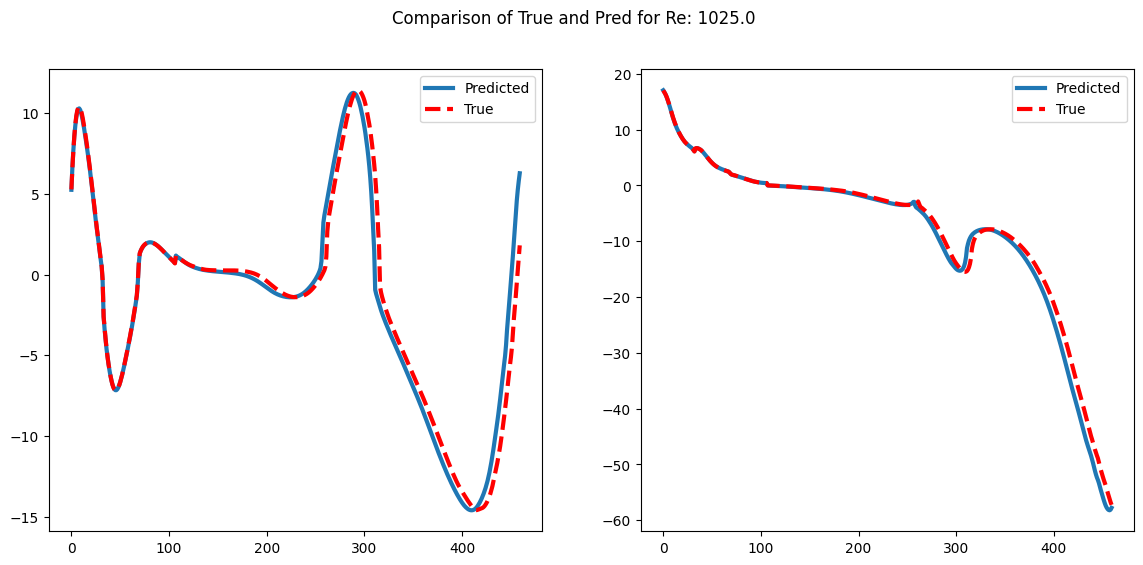

In [40]:
sim_num = 1
time_window = 40
num_time_steps = 500

# We'll do 90 predictions after the initial 10
samples_to_predict = num_time_steps - time_window  # 90

# ---------------------------
# 2) Prepare a rolling buffer & arrays to store predictions
# ---------------------------
input_seq = np.zeros((1, time_window, 3), dtype=np.float32)
predictions = np.zeros((samples_to_predict, 2), dtype=np.float32)
y_true = np.zeros((samples_to_predict, 2), dtype=np.float32)

# Initialize the first 10 steps from the data
input_seq[0, :, :] = lstm_testing_data[sim_num, 0:time_window, :]

# ---------------------------
# 3) Autoregressive loop
# ---------------------------
sample = 0
lstm_model.eval()  # ensure we're in inference mode, no dropout etc.

with torch.no_grad():
    for t in range(time_window, num_time_steps):  # from 10..99
        # Convert to PyTorch tensor
        inp_tensor = torch.from_numpy(input_seq).float()  # shape [1, 10, 3]
        
        # Forward pass
        pred = lstm_model(inp_tensor)               # shape [1, 2]
        pred_np = pred.numpy()[0, :]           # shape [2,]
        
        # Store prediction & ground truth
        predictions[sample, :] = pred_np
        y_true[sample, :] = lstm_testing_data[sim_num, t, 0:2]  # Fix here
        
        # Shift the rolling window by 1
        temp = input_seq[0, 1:time_window, :].copy()
        input_seq[0, 0:time_window-1, :] = temp
        input_seq[0, time_window-1, 0:2] = pred_np
        
        sample += 1

# ---------------------------
# 4) Plot predictions vs. ground truth
# ---------------------------
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot the first latent dimension
ax[0].plot(predictions[:, 0], label='Predicted', linewidth=3)
ax[0].plot(lstm_testing_data[sim_num, time_window:, 0], 'r--', label='True', linewidth=3)
ax[0].legend()

# Plot the second latent dimension
ax[1].plot(predictions[:, 1], label='Predicted', linewidth=3)
ax[1].plot(lstm_testing_data[sim_num, time_window:, 1], 'r--', label='True', linewidth=3)
ax[1].legend()

r_num = (np.unique(lstm_testing_data[sim_num, time_window:, 2])*1000).squeeze()
plt.suptitle(f"Comparison of True and Pred for Re: {r_num}")
plt.show()

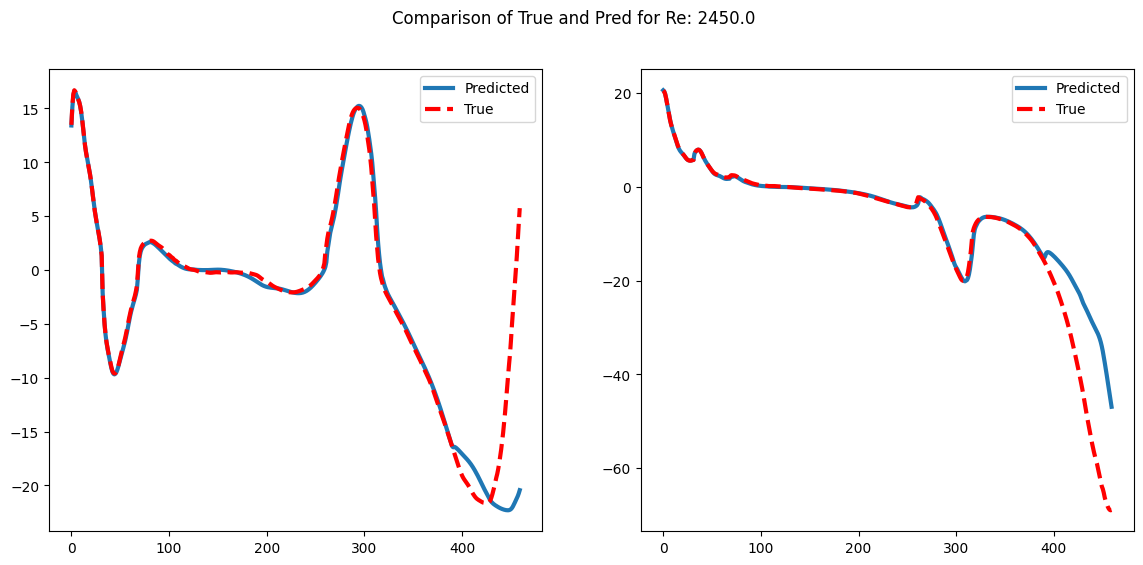

In [41]:
sim_num = -1
time_window = 40
num_time_steps = 500

# We'll do 90 predictions after the initial 10
samples_to_predict = num_time_steps - time_window  # 90

# ---------------------------
# 2) Prepare a rolling buffer & arrays to store predictions
# ---------------------------
input_seq = np.zeros((1, time_window, 3), dtype=np.float32)
predictions = np.zeros((samples_to_predict, 2), dtype=np.float32)
y_true = np.zeros((samples_to_predict, 2), dtype=np.float32)

# Initialize the first 10 steps from the data
input_seq[0, :, :] = lstm_testing_data[sim_num, 0:time_window, :]

# ---------------------------
# 3) Autoregressive loop
# ---------------------------
sample = 0
lstm_model.eval()  # ensure we're in inference mode, no dropout etc.

with torch.no_grad():
    for t in range(time_window, num_time_steps):  # from 10..99
        # Convert to PyTorch tensor
        inp_tensor = torch.from_numpy(input_seq).float()  # shape [1, 10, 3]
        
        # Forward pass
        pred = lstm_model(inp_tensor)               # shape [1, 2]
        pred_np = pred.numpy()[0, :]           # shape [2,]
        
        # Store prediction & ground truth
        predictions[sample, :] = pred_np
        y_true[sample, :] = lstm_testing_data[sim_num, t, 0:2]  # Fix here
        
        # Shift the rolling window by 1
        temp = input_seq[0, 1:time_window, :].copy()
        input_seq[0, 0:time_window-1, :] = temp
        input_seq[0, time_window-1, 0:2] = pred_np
        
        sample += 1

# ---------------------------
# 4) Plot predictions vs. ground truth
# ---------------------------
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot the first latent dimension
ax[0].plot(predictions[:, 0], label='Predicted', linewidth=3)
ax[0].plot(lstm_testing_data[sim_num, time_window:, 0], 'r--', label='True', linewidth=3)
ax[0].legend()

# Plot the second latent dimension
ax[1].plot(predictions[:, 1], label='Predicted', linewidth=3)
ax[1].plot(lstm_testing_data[sim_num, time_window:, 1], 'r--', label='True', linewidth=3)
ax[1].legend()

r_num = (np.unique(lstm_testing_data[sim_num, time_window:, 2])*1000).squeeze()
plt.suptitle(f"Comparison of True and Pred for Re: {r_num}")
plt.show()


In [42]:
sim_num = 0 # we will take re 1050 and re --- [1050., 1250., 1450., 1650., 1850., 2050., 2250., 2450., 2650.]

sim_data = lstm_testing_data[sim_num, :, :]

print(sim_data[:10, :])

[[33.55408096 89.48166656  0.55      ]
 [32.18381119 86.53147888  0.55      ]
 [31.009758   83.41843414  0.55      ]
 [29.95415688 80.18799591  0.55      ]
 [28.24217796 76.90783691  0.55      ]
 [26.85588646 73.67642975  0.55      ]
 [25.2799263  70.84764862  0.55      ]
 [23.6689415  68.2738266   0.55      ]
 [22.42674637 65.66486359  0.55      ]
 [21.53330803 63.0568428   0.55      ]]


In [43]:
print(predictions[:30, :])

[[13.42019   20.597418 ]
 [15.128055  20.387196 ]
 [16.198595  19.820211 ]
 [16.64103   18.85053  ]
 [16.532095  17.7283   ]
 [16.260757  16.573715 ]
 [16.056126  15.430355 ]
 [15.862744  14.371832 ]
 [15.603675  13.456946 ]
 [15.211543  12.660747 ]
 [14.661769  11.943005 ]
 [13.965629  11.278431 ]
 [13.138902  10.618256 ]
 [12.278718   9.926537 ]
 [11.53935    9.25593  ]
 [10.950799   8.66641  ]
 [10.44224    8.169701 ]
 [ 9.956416   7.7794094]
 [ 9.459396   7.4895897]
 [ 8.923193   7.2537155]
 [ 8.304337   7.0217676]
 [ 7.597837   6.759388 ]
 [ 6.862197   6.471778 ]
 [ 6.1519966  6.191023 ]
 [ 5.4929414  5.952774 ]
 [ 4.893651   5.7805824]
 [ 4.351939   5.673713 ]
 [ 3.8558834  5.6168656]
 [ 3.3742883  5.60181  ]
 [ 2.8227217  5.6369824]]


In [44]:
print(y_true[:30, :])

[[13.478326  20.522694 ]
 [15.3130455 20.330906 ]
 [16.327518  19.775328 ]
 [16.688353  18.865665 ]
 [16.572357  17.68555  ]
 [16.286503  16.448807 ]
 [16.028646  15.271421 ]
 [15.833534  14.239162 ]
 [15.594341  13.362617 ]
 [15.23278   12.630868 ]
 [14.715342  11.98642  ]
 [14.035608  11.363372 ]
 [13.215341  10.724843 ]
 [12.330305  10.062207 ]
 [11.532522   9.391584 ]
 [10.905432   8.784001 ]
 [10.373705   8.288869 ]
 [ 9.887555   7.8909817]
 [ 9.417869   7.5654016]
 [ 8.9187565  7.290181 ]
 [ 8.33832    7.0457726]
 [ 7.6455626  6.8034015]
 [ 6.8716326  6.5244956]
 [ 6.1139116  6.224801 ]
 [ 5.4427705  5.9618726]
 [ 4.8563185  5.7681193]
 [ 4.333237   5.6493626]
 [ 3.8479302  5.590226 ]
 [ 3.3644028  5.5804553]
 [ 2.812747   5.625018 ]]


In [45]:
def measure_lstm_prediction_time(
    model,
    lstm_testing_data,
    sim_num,
    final_time,
    time_window=10
):
    """
    Predicts up to `final_time` in a walk-forward manner for simulation `sim_num`,
    measures the elapsed time, and returns the final predicted latent + the true latent.

    Parameters
    ----------
    model : torch.nn.Module
        Your trained PyTorch LSTM model. We'll set model.eval() inside.
    lstm_testing_data : np.ndarray
        Shape (num_test_snapshots, num_time_steps, 3).
        The last dimension typically holds (2 latents + 1 param) or similar.
    sim_num : int
        Which simulation index to use (e.g., 0 for the first).
    final_time : int
        The final timestep index you want to predict up to (>= time_window).
        For example, if time_window=10 and final_time=20, we will predict from t=10..19.
    time_window : int
        Size of the rolling window (default=10).

    Returns
    -------
    float
        Elapsed time (seconds) for performing the predictions from t=time_window up to t=final_time.
    np.ndarray
        The final predicted latent at time=final_time (shape (2,)).
    np.ndarray
        The true latent at time=final_time (shape (2,)).
    """

    # Basic shape info
    num_time_steps = lstm_testing_data.shape[1]
    if final_time > num_time_steps:
        raise ValueError(
            f"final_time={final_time} exceeds available time steps={num_time_steps}."
        )
    if final_time < time_window:
        raise ValueError(
            f"final_time={final_time} is less than time_window={time_window}, no prediction needed."
        )

    # Initialize the rolling window with first `time_window` steps
    input_seq = np.zeros((1, time_window, 3), dtype=np.float32)
    input_seq[0, :, :] = lstm_testing_data[sim_num, 0:time_window, :]

    lstm_model.eval()  # inference mode

    final_pred = None  # store the final predicted latent
    start_time = time.time()

    with torch.no_grad():
        # Predict from t=time_window to t=final_time-1
        # so that at the end of the loop we've generated a prediction for index final_time.
        # If you want the model's prediction at final_time itself, we do a loop up to final_time.
        for t in range(time_window, final_time):
            inp_tensor = torch.from_numpy(input_seq).float()  # shape [1, 10, 3]
            pred = lstm_model(inp_tensor)  # shape [1, 2]
            pred_np = pred.numpy()[0, :]  # shape (2,)

            # Shift the rolling window
            temp = input_seq[0, 1:time_window, :].copy()
            input_seq[0, 0:time_window - 1, :] = temp
            input_seq[0, time_window - 1, 0:2] = pred_np

            # Keep track of the last prediction
            final_pred = pred_np
            
    x_hat_tau_pred = decoder(torch.tensor(final_pred, dtype = torch.float32))
    
    end_time = time.time()
    
    elapsed = end_time - start_time

    # final_pred is the LSTM's predicted latent for step `final_time`.
    # The *true* latent at that time is:
    final_true = lstm_testing_data[sim_num, final_time, 0:2]  # shape (2,)

    return elapsed, final_pred, final_true


In [46]:
# Example usage:
lstm_model.eval()
sim_num = 0
final_time = 475  # predict the 480th latent
elapsed_sec, pred_latent, true_latent = measure_lstm_prediction_time(
    lstm_model, lstm_testing_data, sim_num, final_time, time_window=40
)

print(f"Time to predict up to t={final_time}: {elapsed_sec:.4f} s")
print("Predicted latent at final_time:", pred_latent)
print("True latent at final_time:", true_latent)

Time to predict up to t=475: 0.2477 s
Predicted latent at final_time: [  1.4871125 -46.88186  ]
True latent at final_time: [ -6.60006714 -33.96752548]


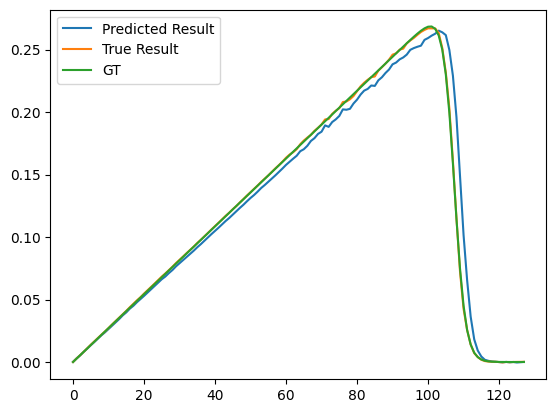

In [47]:
# Passing the latent into the decoder:
x_hat_tau_pred = decoder(torch.tensor(pred_latent, dtype = torch.float32))
x_hat_tau = decoder(torch.tensor(true_latent, dtype = torch.float32))
exact = exact_solution(rnum_vals_test[sim_num]*1000, final_time*dt)
plt.plot(x_hat_tau_pred.cpu().detach().numpy(), label = "Predicted Result")
plt.plot(x_hat_tau.cpu().detach().numpy(), label = "True Result")
plt.plot(exact, label = "GT")

plt.legend()

In [49]:
# Saving the model weights: Model, Decoder, LSTM
lstm_path = "./lstm_weights.pth"
torch.save(lstm_model.state_dict(), lstm_path)

# Saving the model weights: Model, Decoder, LSTM
encoder_path = "./ae_encoder_weights.pth"
torch.save(encoder.state_dict(), encoder_path)

decoder_path = "./ae_decoder_weights.pth"
torch.save(decoder.state_dict(), decoder_path)

model_path = "./ae_model.pth"
torch.save(model.state_dict(), model_path)